# Ubiquant market prediction : EDA, PCA and Linear Regression

The objective of this notebook;

-To analysis of the dataset of Ubiquant market prediction,
- To apply PCA on a sample of the dataset
- Linear Regression used for predictions.

Several ideas are picked up from this kernel https://www.kaggle.com/code/bastiendelaval/analyse-oc such as correlations and PCA.

## Librairies

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import random

# Get files content
import os
import joblib

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings(action="ignore")

# scipy tools
from scipy.stats.stats import pearsonr

# sklearn tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    learning_curve,
    cross_validate,
    KFold,
    TimeSeriesSplit,
)

## Data importation

We use parquet version of the dataset thanks to this kernel https://www.kaggle.com/code/camilomx/parquet-format-quickstart.

In [2]:
%%time

# Import dataset
df = pd.read_parquet("../input/ubiquant-parquet-low-mem/train_low_mem.parquet")

CPU times: user 11.1 s, sys: 26.4 s, total: 37.4 s
Wall time: 43.6 s


## viewing the dataset

In [3]:
# Display first rows
df.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


There are 300 features named "f_i" for i in (0, 300). 

There is the target named "target".

Row_id is indexed on investment_id time_id.

For each column time_id value, there are several investment_id.

In [4]:
# Dimension
df.shape

(3141410, 304)

In [5]:
# Info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


304 columns and more than 3M of rows.

Column row_id is dtype object.

In [6]:
print("Columns of dtype uint16 : ")
for col in df.select_dtypes("uint16"):
    print(col)

Columns of dtype uint16 : 
time_id
investment_id


In [7]:
# Data summary
df.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


Features seem to have low values (< 100) and can get be negative, even for the target.

As the means are very close to zero, we can consider that features f had already been standardized.

In [8]:
# Check if there are missing values
df.isnull().sum().sum()

0

There is no missing value.

### Reduce memory usage of the dataset
Many kernels use this function to reduce the memory usage of the dataset (to avoid Memory-over error). I didn't find the original kernel that introduce this.

Be careful it takes a long time.

EDIT : it seems that there is a lost of information, especially when we get the describe information. I am not sure if it is a good idea.

I wrote a notebook about it https://www.kaggle.com/code/larochemf/ubiquant-low-memory-use-be-careful. It seems that some lines have to be changed. Nevertheless, I finally did not use this function.

In [9]:
%%time

def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2

    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


df_1 = reduce_mem_usage(df)

Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%
CPU times: user 2min 1s, sys: 2min 45s, total: 4min 47s
Wall time: 4min 47s


In [10]:
# Data summary
df_1.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3141410.0,3141410.0,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,NaN,NaN,NaN,1.633644e-03,-1.258850e-02,8.499146e-03,-1.992798e-02,-5.428314e-03,-3.021240e-03,1.940727e-03,...,1.258850e-02,8.964539e-04,-6.500244e-03,2.836227e-03,-4.730225e-03,NaN,-1.508713e-03,-7.053375e-03,-4.215240e-03,-4.329681e-03
std,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.0,0.0,-9.421875e+00,-1.765625e+01,-6.578125e+00,-8.640625e+00,-1.800000e+01,-4.000000e+00,-8.835938e+00,-6.382812e+00,...,-9.273438e+00,-6.359375e+00,-8.187500e+00,-2.400000e+01,-1.497656e+01,-9.351562e+00,-7.367188e+00,-7.578125e+00,-6.707031e+00,-1.028125e+01
25%,353.0,952.0,-5.004883e-01,-4.072266e-01,-6.811523e-01,-6.533203e-01,-4.497070e-01,-3.532715e-01,-7.070312e-01,-7.910156e-01,...,-6.035156e-01,-8.354492e-01,-6.982422e-01,-1.376953e-01,-9.399414e-01,-5.146484e-01,-9.575195e-01,-7.241211e-01,-8.164062e-01,-5.078125e-01
50%,704.0,1882.0,-9.716797e-02,2.431641e-01,-4.867554e-02,4.351807e-02,-2.639160e-01,-1.909180e-01,-2.145386e-02,1.438141e-02,...,6.085205e-02,-2.022705e-01,-1.910400e-01,2.164307e-01,2.087402e-01,-2.907715e-01,6.954193e-03,-1.650391e-01,2.301025e-02,-2.824707e-01
75%,975.0,2830.0,3.571777e-01,6.650391e-01,6.088867e-01,6.586914e-01,7.763672e-02,2.784729e-02,6.835938e-01,8.007812e-01,...,6.884766e-01,9.038086e-01,4.841309e-01,5.087891e-01,8.618164e-01,1.275635e-01,9.501953e-01,6.098633e-01,7.983398e-01,1.411133e-01
max,1219.0,3772.0,1.203906e+01,7.843750e+00,8.710938e+00,8.007812e+00,4.706250e+01,7.662500e+01,7.644531e+00,6.777344e+00,...,9.296875e+00,9.726562e+00,2.231250e+01,6.585938e+00,6.976562e+00,6.140625e+01,7.679688e+00,1.242188e+01,7.003906e+00,4.337500e+01


## Features analysis

We are going to analyse features, with some points taken from this kernel https://www.kaggle.com/code/jiahauc/ubiqunt-eda-linearregression
### Investment

In [11]:
investments = df["investment_id"].nunique()
print("Number of unique investiment_id : ", investments)

Number of unique investiment_id :  2788


In [12]:
df["investment_id"].value_counts()

2752.0    3576
3052.0    3528
3304.0    3516
2356.0    3514
2712.0    3510
          ... 
85.0         8
905.0        8
2558.0       8
3662.0       7
1415.0       2
Name: investment_id, Length: 2788, dtype: int64

It seems that several investments have low frequency. Let's have a look at investment_id = 905.

In [13]:
df.loc[df["investment_id"] == 905]

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3114764,1212_905,1212.0,905.0,0.000000,-0.252197,1.872070,0.0,4.925781,0.670410,-0.845703,...,-0.311768,-0.770996,5.261719,0.484131,1.284180,5.691406,0.902832,-0.551758,0.000000,-0.747559
3118203,1213_905,1213.0,905.0,0.000000,0.493896,1.320312,0.0,3.734375,0.778320,1.180664,...,-0.295898,-0.635254,4.656250,1.114258,0.785645,5.433594,0.859375,-0.394043,0.000000,-0.744141
3121643,1214_905,1214.0,905.0,2.146484,0.550293,0.807129,0.0,3.269531,0.757812,1.683594,...,-0.274170,-0.718262,2.626953,0.920410,-0.713379,3.414062,1.051758,-0.598145,0.000000,5.406250
3125082,1215_905,1215.0,905.0,-1.416016,0.559082,0.318848,0.0,3.273438,0.761230,1.991211,...,-0.979492,-0.694824,-0.071411,0.769043,0.966797,2.679688,1.137695,-0.651855,0.000000,5.050781
3128514,1216_905,1216.0,905.0,1.966797,0.782715,-0.057007,0.0,3.912109,0.814941,2.457031,...,-0.241333,-0.730957,0.745605,-1.161133,0.857910,2.376953,0.944336,-0.917480,2.228516,5.242188
3131924,1217_905,1217.0,905.0,1.357422,0.672852,-0.451416,0.0,3.066406,0.751465,1.683594,...,-0.221924,-1.651367,0.945801,0.405518,-1.481445,1.855469,0.611328,-0.768555,2.031250,5.097656
3135350,1218_905,1218.0,905.0,-1.402344,0.289551,-0.486572,0.0,3.390625,0.796875,-1.569336,...,0.102722,1.220703,0.464111,0.482178,-1.033203,2.160156,1.131836,1.375977,1.838867,5.093750
3138783,1219_905,1219.0,905.0,-3.046875,0.482910,-0.330078,0.0,3.816406,0.826172,-1.804688,...,-0.818848,0.811523,-0.613281,-1.142578,0.421631,2.611328,1.363281,4.093750,1.701172,4.792969


This investment is only present at this end of the dataset.

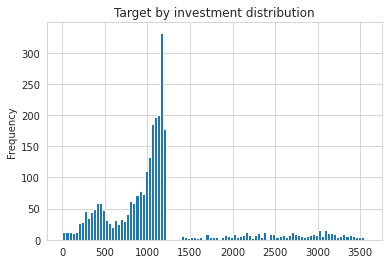

In [14]:
# Let's group by investment_id and see distribution
obs_by_investments = df.groupby(["investment_id"])["target"].count()

obs_by_investments.plot(kind="hist", bins=100)
plt.title("Target by investment distribution")
plt.show()

There are more targets with investment_id with high values count.

In [15]:
# Get mean values of the target when groupping by investment_id
mean_targets = df.groupby(["investment_id"])["target"].mean()
mean_targets

investment_id
0.0       0.052826
1.0      -0.025681
2.0      -0.051117
3.0       0.046753
4.0      -0.047760
            ...   
3764.0   -0.013916
3766.0   -0.057709
3768.0   -0.038025
3770.0   -0.072998
3772.0   -0.014458
Name: target, Length: 2788, dtype: float16

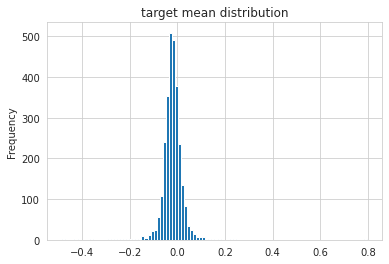

In [16]:
# Plot these means distributions
mean_targets.plot(kind="hist", bins=100)
plt.title("target mean distribution")
plt.show()

Target mean distribution is close to normal distribution.

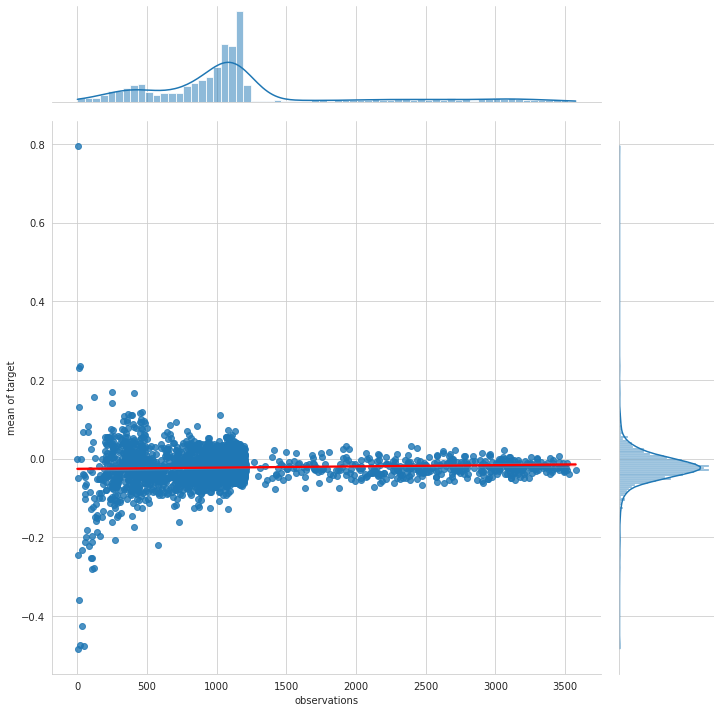

In [17]:
ax = sns.jointplot(
    x=obs_by_investments,
    y=mean_targets,
    kind="reg",
    height=10,
    joint_kws={"line_kws": {"color": "red"}},
)
ax.ax_joint.set_xlabel("observations")
ax.ax_joint.set_ylabel("mean of target")
plt.show()

Through this joint plot of observations in each investment and mean target value in each investment, it shows there is a growing trend when the observations increase. Also, the dispersion of target values is more apparent when the number of recorded investments is relatively low.

### time_id

In [18]:
timestamps = df["time_id"].nunique()
print("Number of unique time_id : ", timestamps)

Number of unique time_id :  1211


In [19]:
df["time_id"].value_counts()

1214.0    3445
1209.0    3444
1211.0    3440
1207.0    3440
1208.0    3438
          ... 
415.0      659
362.0      651
374.0      600
398.0      539
492.0      512
Name: time_id, Length: 1211, dtype: int64

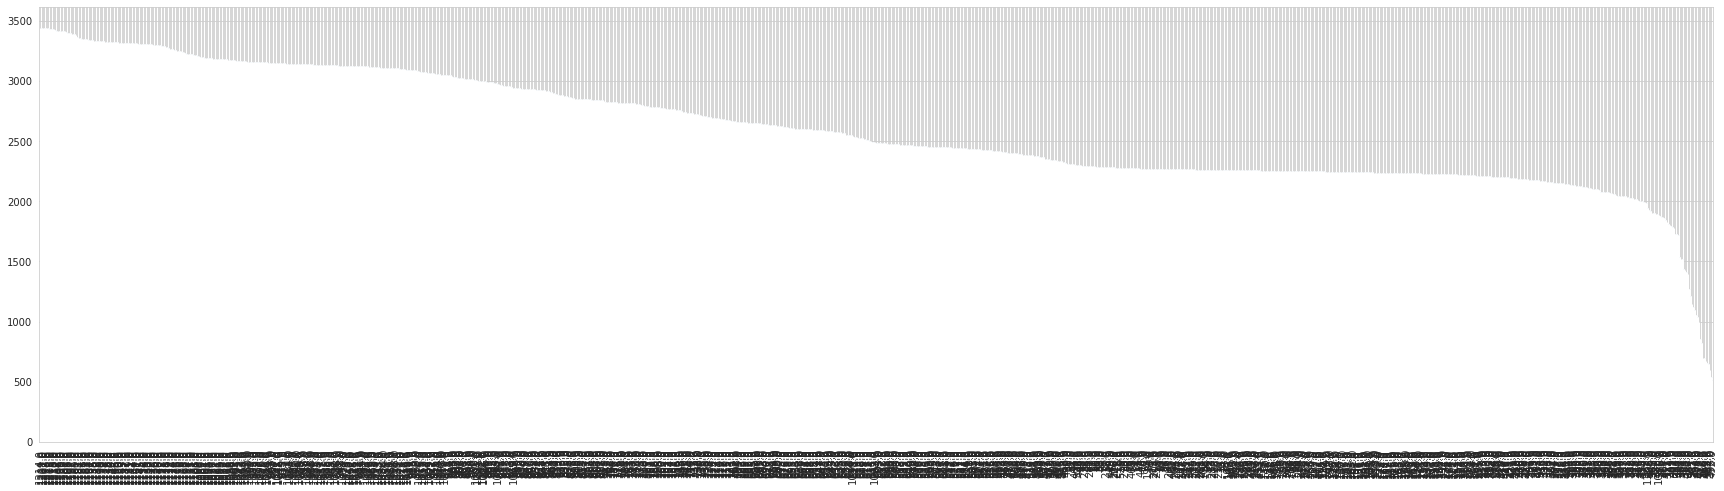

In [20]:
plt.figure(figsize=(30, 8))
df["time_id"].value_counts().plot(kind="bar")
plt.show()

In [21]:
print(
    "Percent of time_id value_counts >= 2000 : {}%".format(
        round(
            (df["time_id"].value_counts() >= 2000).sum()
            / len(df["time_id"].value_counts())
            * 100,
            1,
        )
    )
)

Percent of time_id value_counts >= 2000 : 95.8%


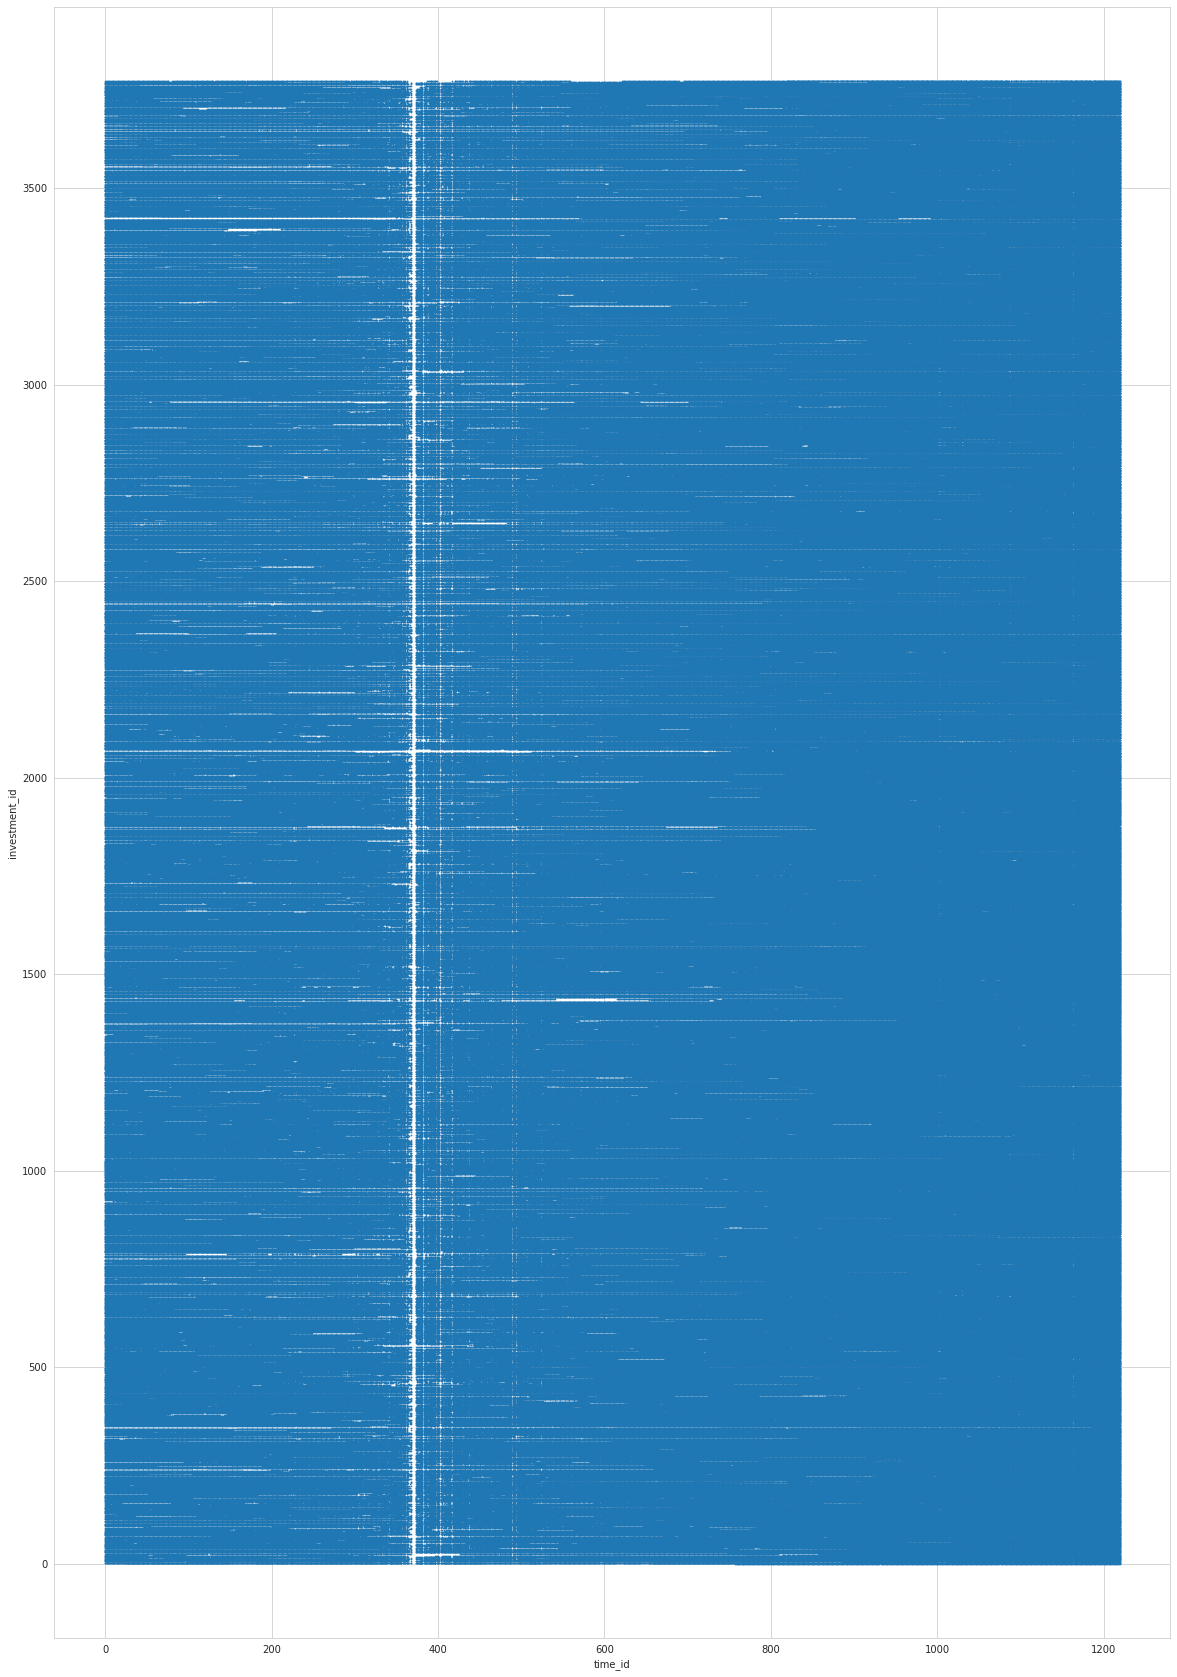

In [22]:
# Let's plot investment_id and time_id together
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.show()

We can see that investment_id are more present with high time_id.

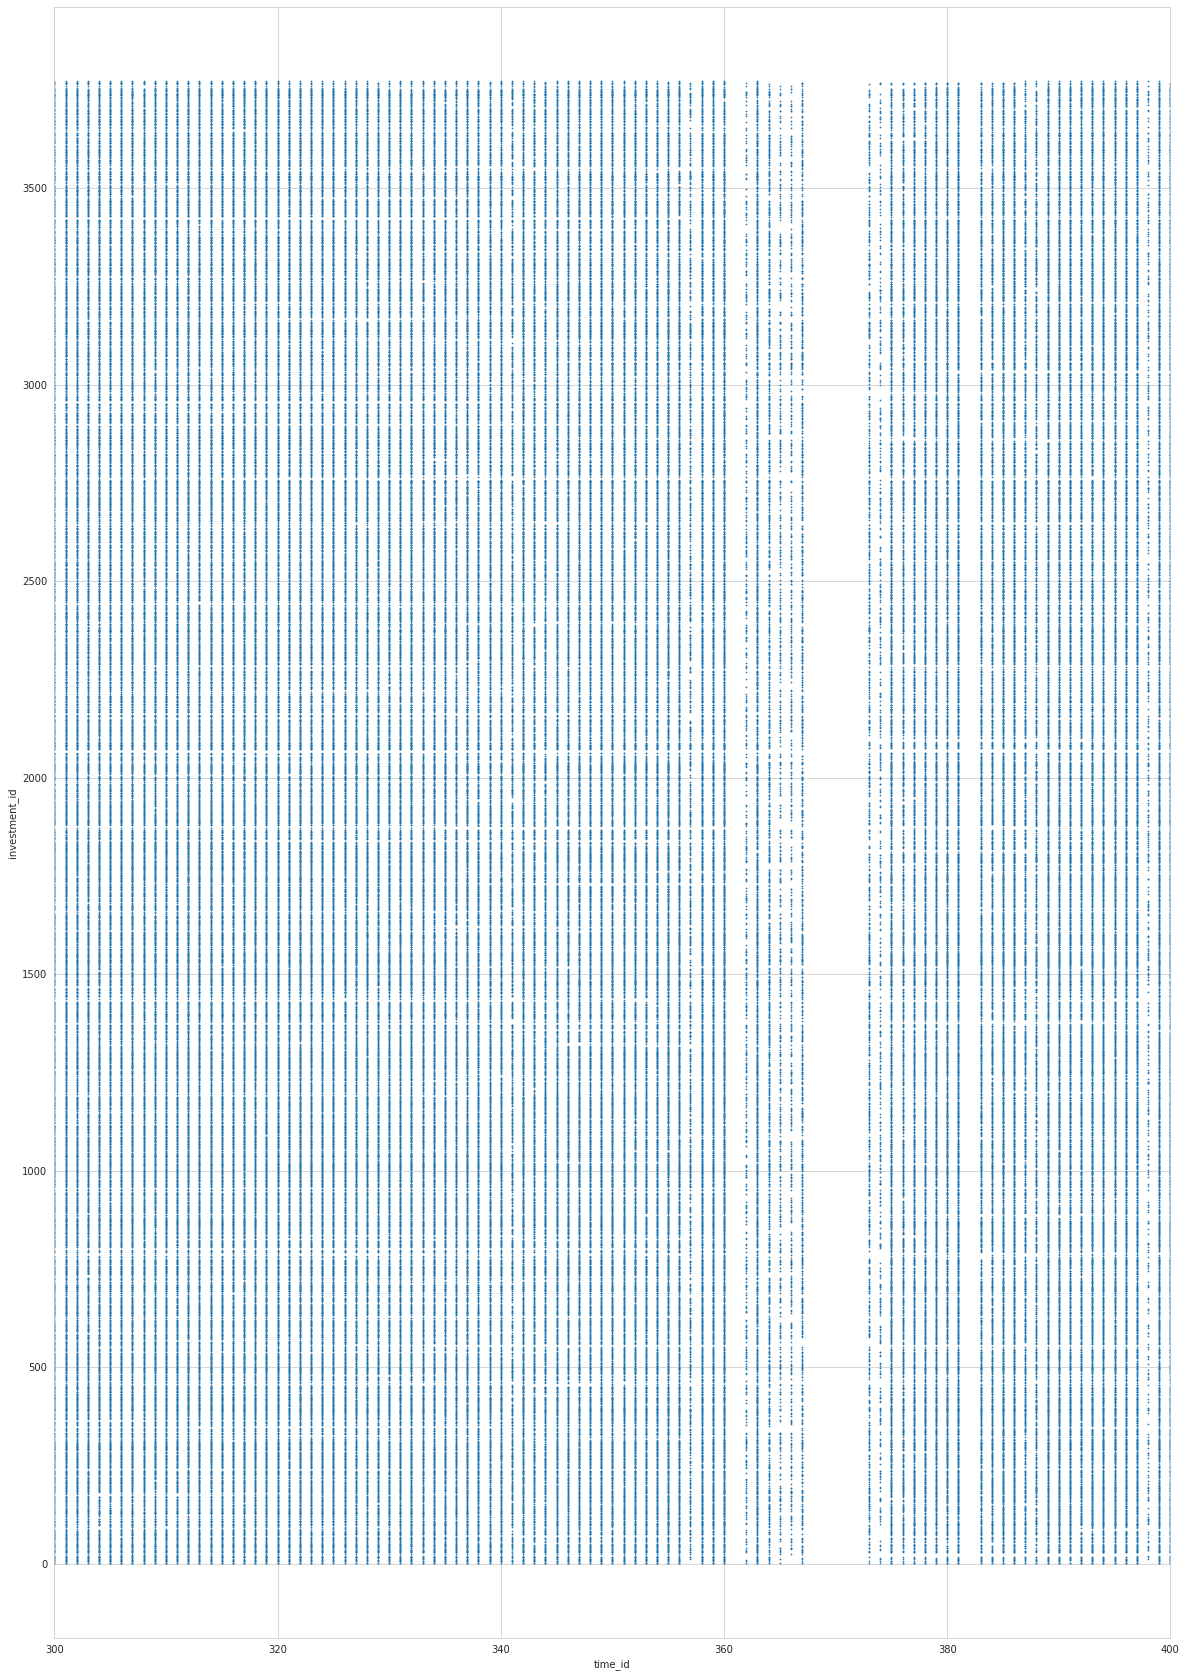

In [23]:
# Let's see what's happenning around 300-400 time_id.
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.xlim(300, 400)
plt.show()

We can see that there are some missing time_id.

### Features f_i
A histogram of all features is available at this kernel https://www.kaggle.com/code/mk1001/eda-f-0-299-histogram/notebook.

Let's see randomly six of them with boxplot :

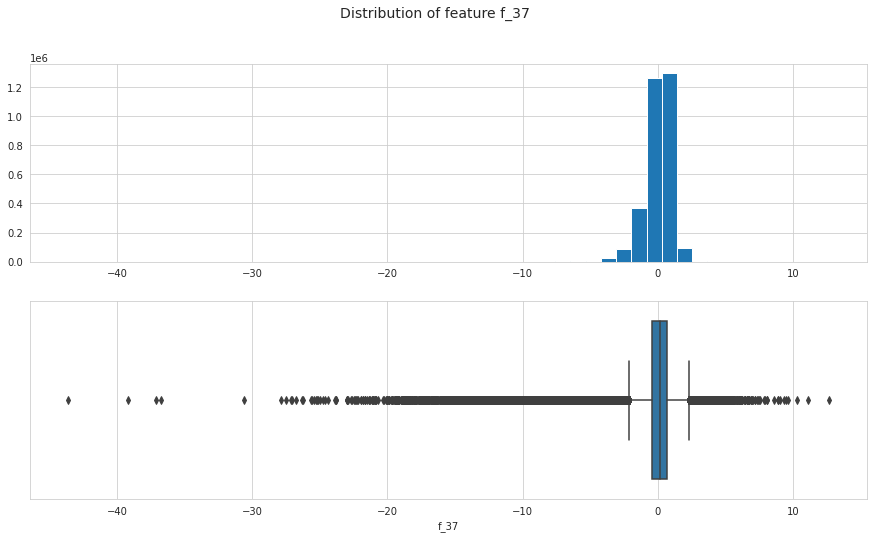

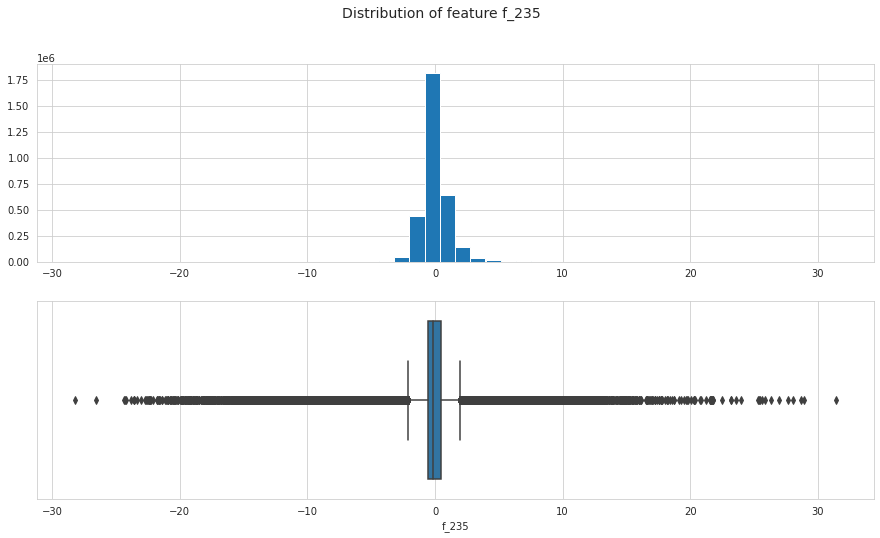

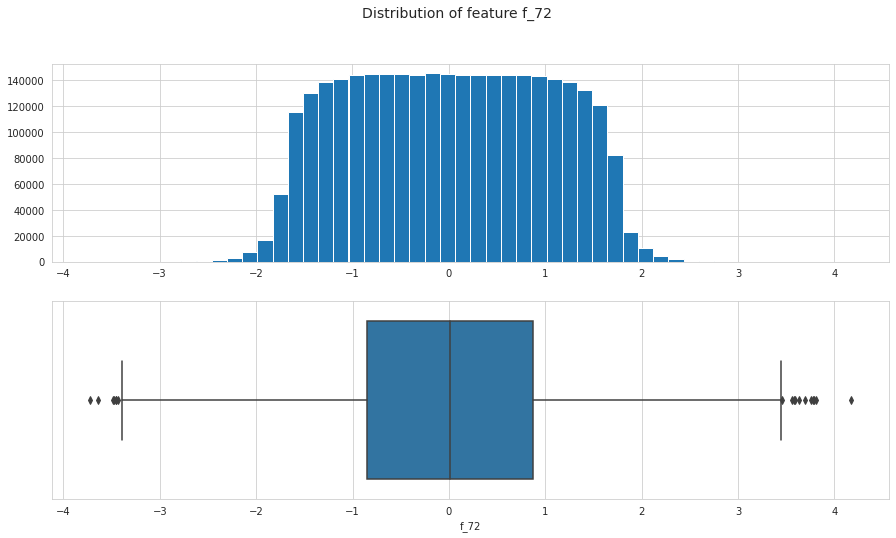

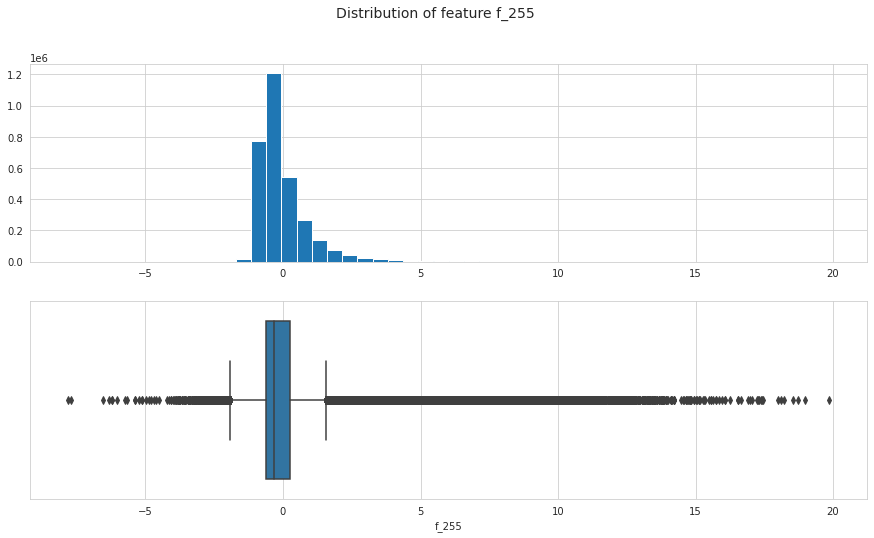

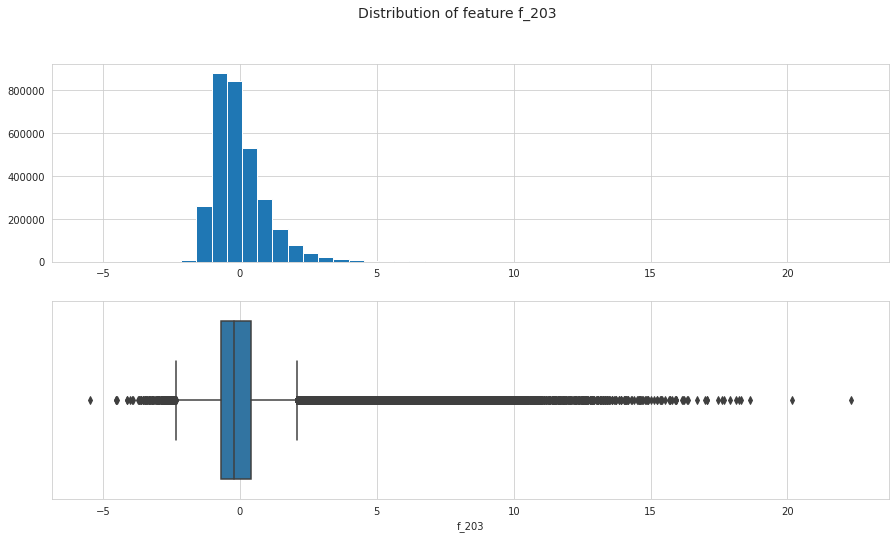

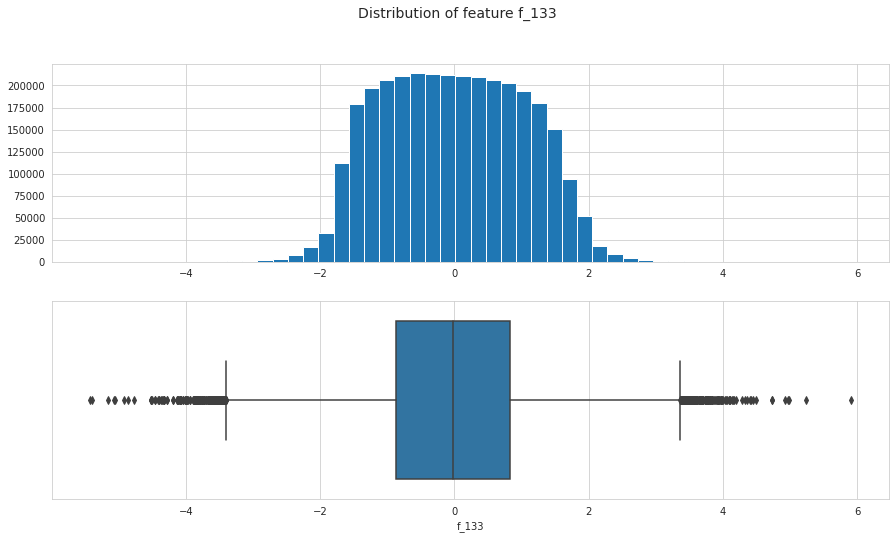

In [24]:
np.random.seed(1)

# Plot randomly 6 histograms and boxplots of features f_
for f in np.random.choice(range(0, 300), 6):
    
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature f_{}".format(f), size=14)
    
    # Target histogram
    df["f_{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="f_{}".format(f), data=df, ax=axes[1])
    plt.show()

Some features are centered in zero.

Some of them get outliers as the distribution is not centered. So maybe, in the future we could consider to normalize data with a Robust Scaler in order to limit the influence of outliers.

In [25]:
# List of features columns
features = [f"f_{i}" for i in range(0, 300)]

### Target
Let's see the target distribution.

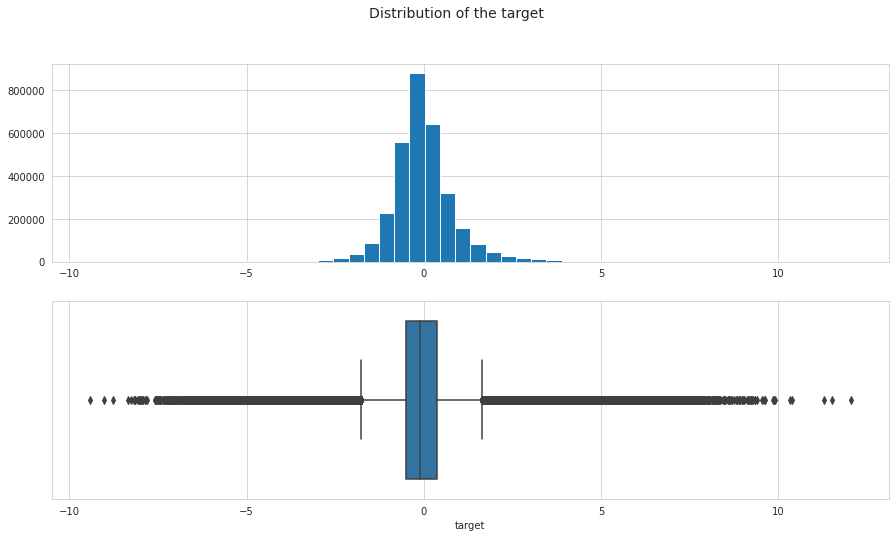

In [26]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=df, ax=axes[1])
plt.show()

In [27]:
mean_target = df["target"].mean()
std_target = df["target"].std()
print("Target mean value : ", mean_target)
print("Target std value : ", std_target)

Target mean value :  nan
Target std value :  0.0


The distribution seems to be gaussian.

Let's plot the target distribution for some investment_id :

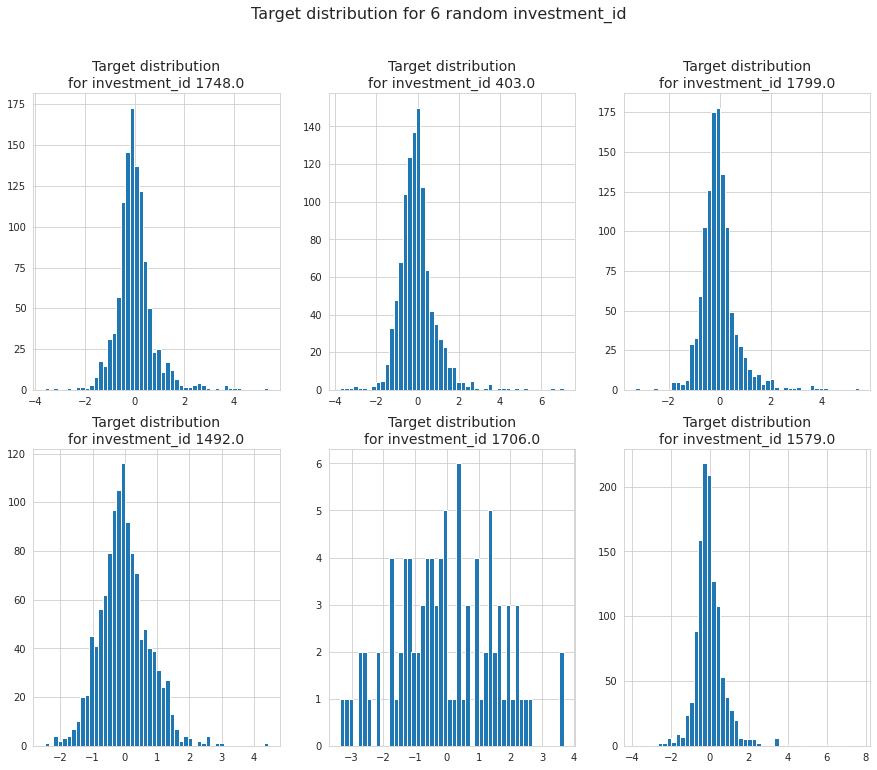

In [28]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Target distribution for 6 random investment_id", size=16)

# Plot randomly 6 histograms of the target
for j in np.random.choice(df["investment_id"].unique(), 6):
    plt.subplot(2, 3, i)
    df[df["investment_id"] == j]["target"].hist(bins=50)
    plt.title("Target distribution\nfor investment_id {}".format(j), size=14)
    i += 1

For individual investment_id, target distribution seems to be less gaussian. Some values are high for values being at the "tail of the distribution" (e.g. investment_id 2441, 1337).

## Bidimensional analysis
### Get a sample dataset
Let's take a sample of the data.

In [29]:
sample_df = df.sample(frac=0.05, random_state=1)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
607231,270_482,270.0,482.0,1.393555,0.563965,0.329590,-1.315430,1.401367,0.016632,1.121094,...,0.847656,-0.819824,0.835449,0.319824,0.555176,0.556152,1.071289,-0.586426,-0.412109,0.412842
1435447,653_1885,653.0,1885.0,0.444092,-0.293701,0.655762,2.351562,0.026230,-0.572754,-0.872070,...,0.014076,-0.768066,-0.457275,0.472168,0.967773,-0.637695,-1.078125,-1.184570,-0.521973,-0.691406
1719449,759_3490,759.0,3490.0,0.280762,0.164307,0.873047,0.018524,-0.321289,-0.169800,-1.195312,...,-0.117676,1.044922,-0.246948,0.198608,-1.068359,-0.164551,-0.911133,0.178223,-0.027954,-0.385254
2166750,914_2149,914.0,2148.0,1.096680,0.941406,0.873535,-1.989258,2.851562,0.489014,1.074219,...,-1.243164,-1.019531,3.755859,0.844238,-1.029297,2.517578,1.265625,0.255859,0.758301,-0.830078
399169,176_3484,176.0,3484.0,-0.114746,0.870117,0.410645,1.002930,-0.255859,-0.539062,-1.188477,...,-0.753906,-0.516113,0.544434,0.150024,2.001953,-0.556152,-1.540039,0.551758,0.379639,-0.777832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248400,940_3636,940.0,3636.0,0.008492,0.935059,-1.456055,1.541992,-0.427490,-0.289551,-0.174072,...,-0.033173,0.862793,-0.354980,0.319336,1.098633,-0.516602,1.039062,-0.499268,1.388672,-0.535156
778810,350_919,350.0,919.0,-0.375977,-1.357422,-0.255859,0.837891,-1.442383,-0.489990,0.982422,...,-0.508789,-0.750977,-1.239258,0.099487,-1.540039,-0.880371,0.082336,-0.853027,1.616211,-0.303467
258031,113_3187,113.0,3188.0,-0.271240,0.714355,1.133789,0.130737,-0.395020,-0.343506,-0.903809,...,-0.381104,-0.588379,0.042725,0.385742,-0.609375,-0.363525,-0.129761,-0.550293,0.961914,-0.769043
2866111,1137_1967,1137.0,1967.0,-0.059479,-1.663086,0.263916,-0.863281,-0.418945,-0.195190,1.982422,...,0.107849,1.126953,-0.318115,1.135742,1.022461,-0.328613,1.280273,0.640625,0.185425,-0.297119


In [30]:
# Sort by time_id and investment_id to get data in order 
# and reset index
sample_df = sample_df.sort_values(
    ["time_id", "investment_id"], ascending=[True, True]
).reset_index(drop=True)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_19,0.0,19.0,0.686035,0.025284,-0.011871,-0.390625,-0.600586,-0.218506,1.252930,...,0.333740,0.912598,-0.122070,0.819336,-1.060547,-0.169189,0.104919,0.405029,-0.261230,-0.050018
1,0_98,0.0,98.0,0.586426,0.677246,-0.011871,-0.523926,0.419922,-0.114319,1.741211,...,-1.146484,0.912598,0.669922,0.819336,0.941406,-0.128418,1.296875,1.315430,-0.943848,-0.220581
2,0_173,0.0,173.0,1.077148,0.353027,0.615723,-0.082886,0.778320,0.159424,1.843750,...,0.365967,0.912598,1.797852,0.819336,-1.060547,0.884766,-1.086914,-1.365234,-1.131836,0.185547
3,0_315,0.0,315.0,1.121094,0.861328,1.495117,-0.089600,1.295898,0.006027,0.402832,...,-1.146484,0.912598,3.382812,0.819336,-1.060547,0.007828,-1.086914,0.297363,-1.429688,0.683594
4,0_335,0.0,335.0,3.162109,0.736328,0.113708,-1.845703,3.023438,-0.074768,1.738281,...,-0.609863,-1.095703,1.809570,-1.220703,-1.060547,0.268066,1.296875,-1.518555,0.887695,0.814453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157065,1219_3617,1219.0,3616.0,-1.082031,-0.015137,1.361328,1.455078,-0.448486,0.707031,-1.978516,...,0.137695,0.811523,0.138672,0.875488,0.421631,2.439453,1.363281,0.802734,1.019531,2.740234
157066,1219_3624,1219.0,3624.0,-1.027344,-0.685547,-0.720215,1.109375,-0.442139,-0.095154,0.119568,...,1.125000,0.811523,-0.477783,-1.142578,0.421631,-0.163208,-0.075562,0.166870,0.020752,-0.040680
157067,1219_3679,1219.0,3680.0,1.321289,0.688477,-0.590332,1.097656,-0.458008,-0.101379,0.555664,...,3.007812,0.811523,1.207031,-1.142578,0.421631,-0.334717,-1.514648,0.016251,0.097290,-0.155518
157068,1219_3759,1219.0,3760.0,-0.059479,0.498047,0.840820,0.310791,0.141479,0.500977,0.015717,...,-0.301514,0.811523,-0.282959,-1.142578,0.421631,1.311523,-1.514648,-0.808594,-1.035156,0.726074


In [31]:
# Dataframe information
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157070 entries, 0 to 157069
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(303)
memory usage: 179.8 MB


Check the target distribution

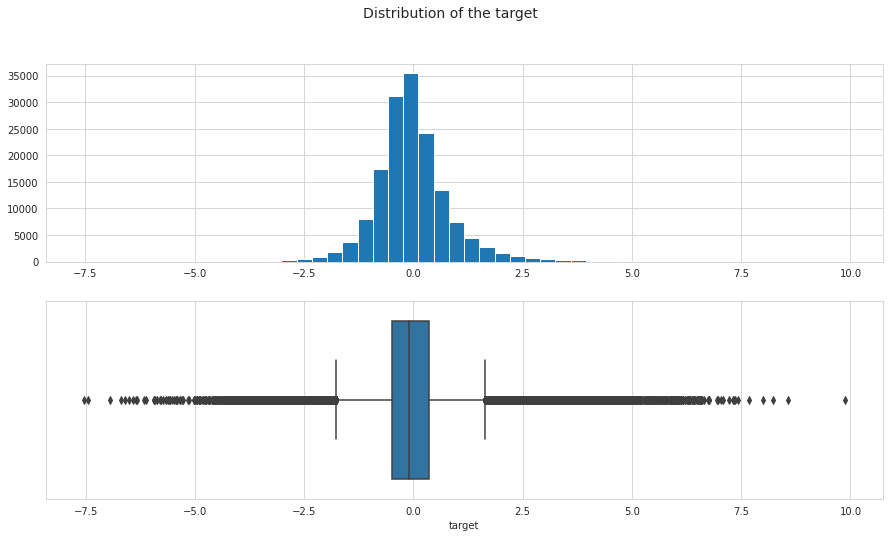

In [32]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
sample_df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=sample_df, ax=axes[1])
plt.show()

Distribution is close to the one in the full dataset, but we don't have outliers above 10 and less than 8 as there are in the full dataset.


### Correlation
#### Target vs features
Let's see if the target is correlated to the features f_i.

In [33]:
correlation = sample_df[["target"] + features].corr()

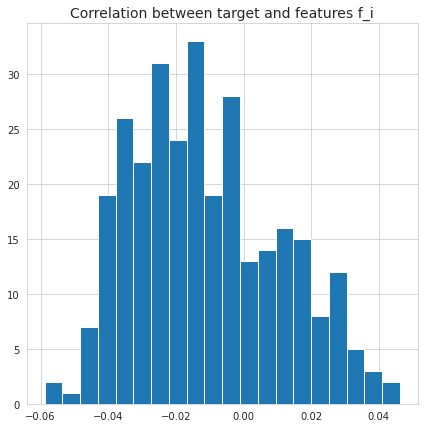

In [34]:
# Plot correlation values between target and features f_i
plt.figure(figsize=(7, 7))
correlation["target"].iloc[1:].hist(bins=20)
plt.title("Correlation between target and features f_i", size=14)
plt.show()

Correlation values are very low, so it means that target is not linked to features.
#### Between features
Let's see the correlation between the features f_i. As there are 300 features, it is difficult to see all correlations.

In [35]:
def mat_corr(df):
    """
    Function to plot correlation matrix heatmap between columns of a dataframe
    
    Arguments :
    - dataframe df
    
    Display :
    - correlation matrix as heatmap
    """

    # Compute correlation
    corr = df.corr()

    # Mask to display only lower part of the heatmap
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot initialization
    f, ax = plt.subplots(figsize=(30, 30))

    # Color mapping
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        # vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar=True,
        # annot=True, # do not display correlation values
    )
    plt.title("Correlation Matrix", size=20)
    plt.show()

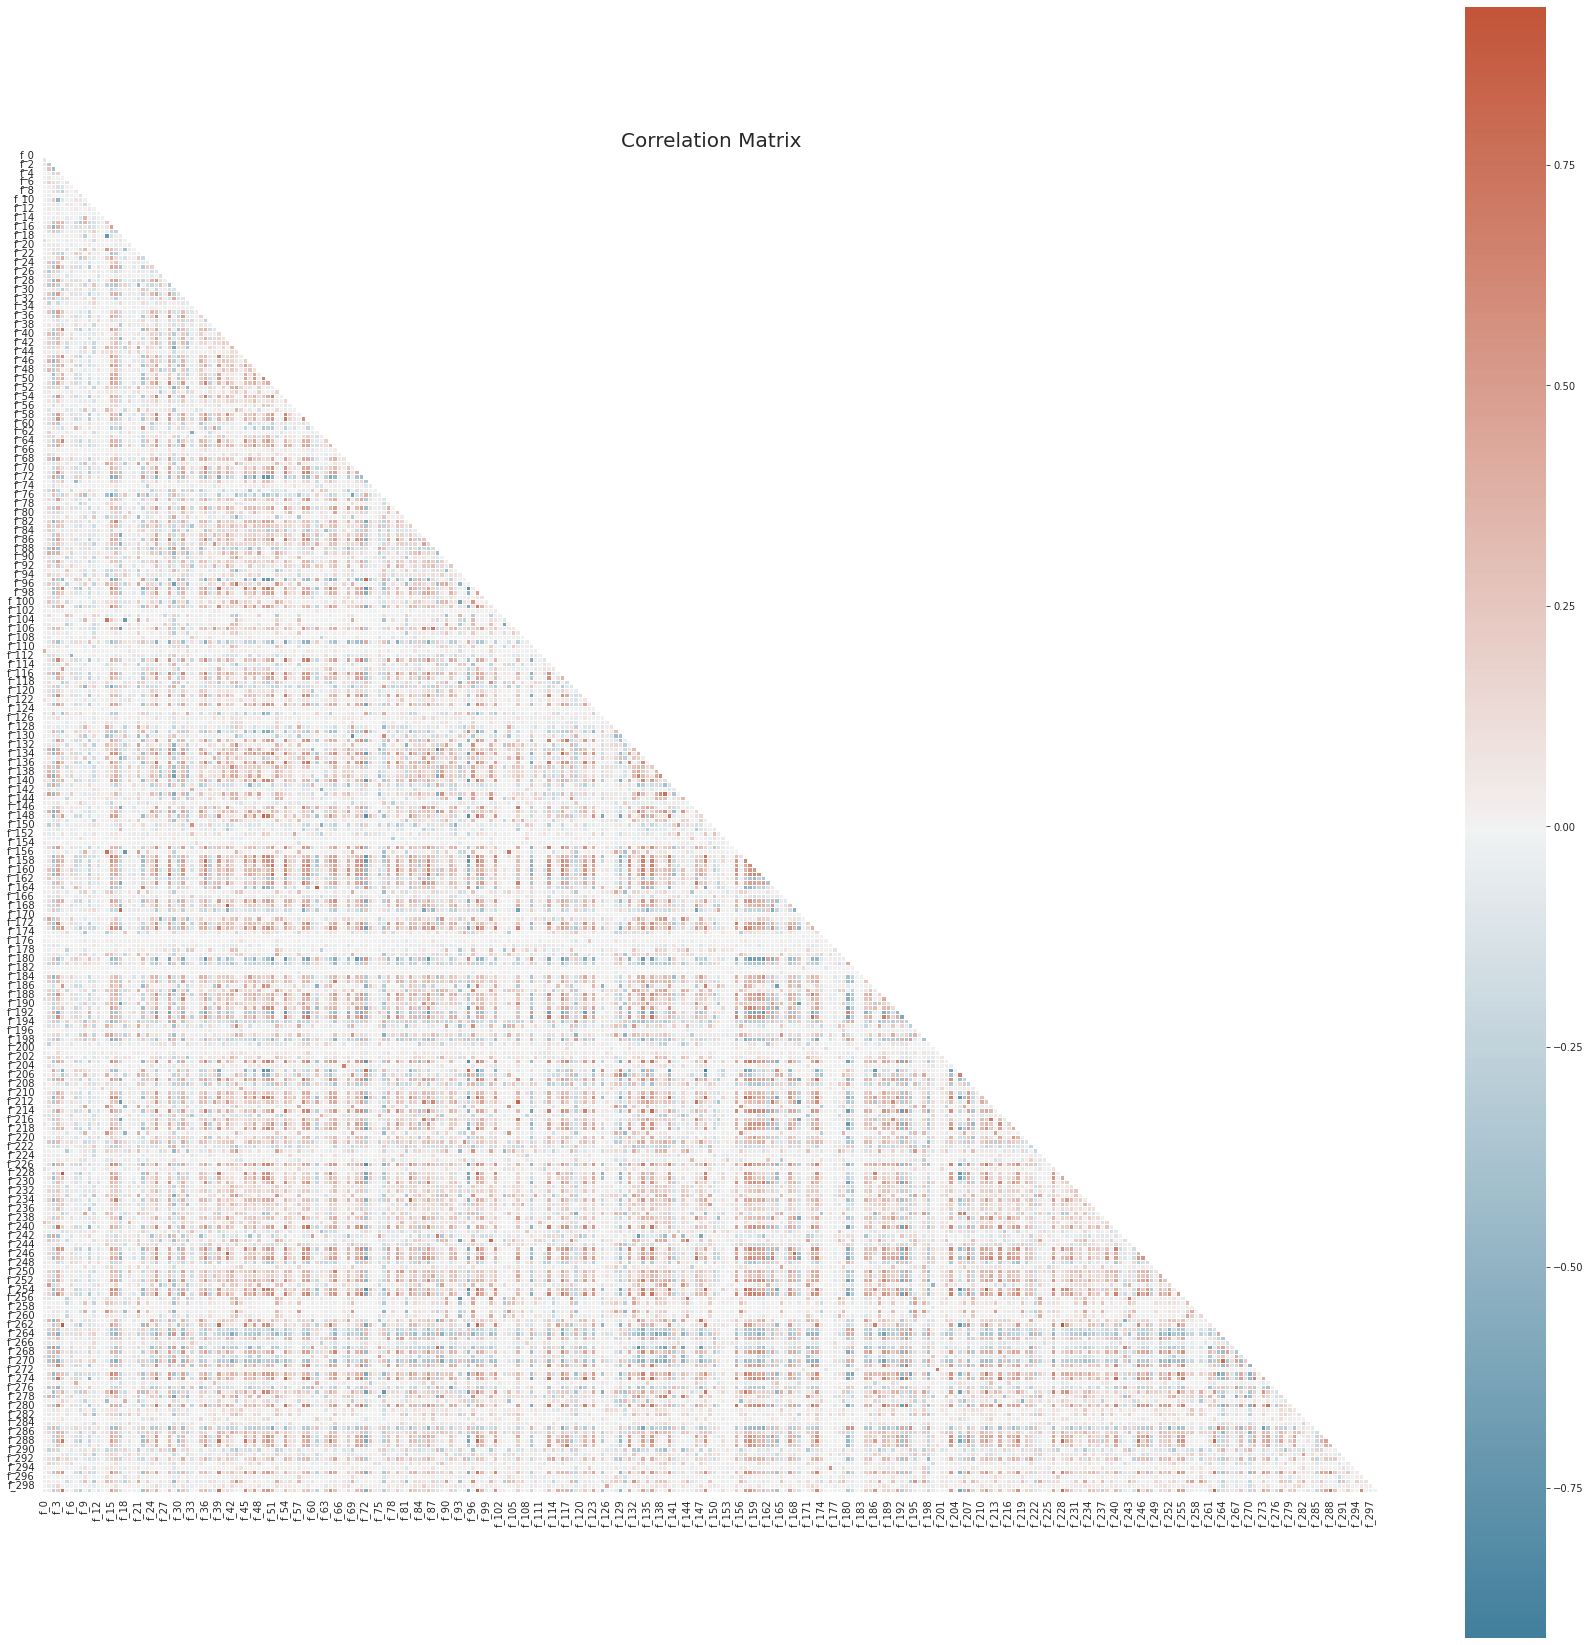

In [36]:
# Display heatmap
mat_corr(sample_df[features])

Most of correlations are low. 

We are going to see the highest correlations. Generally, it is considered that high correlation is above 0.8.

In [37]:
# Compute correlation matrix with absolute values
corr_matrix = sample_df[features].corr().abs()

# Keep high correlations
high_corr_var = np.where(corr_matrix >= 0.80)

# Get pairs of features with high correlations
high_corr_var = [
    (corr_matrix.columns[x], corr_matrix.columns[y])
    for x, y in zip(*high_corr_var)
    if x != y and x < y
]
high_corr_var

[('f_4', 'f_228'),
 ('f_4', 'f_262'),
 ('f_17', 'f_169'),
 ('f_28', 'f_161'),
 ('f_39', 'f_97'),
 ('f_41', 'f_168'),
 ('f_41', 'f_246'),
 ('f_49', 'f_148'),
 ('f_49', 'f_205'),
 ('f_61', 'f_164'),
 ('f_72', 'f_95'),
 ('f_72', 'f_226'),
 ('f_82', 'f_234'),
 ('f_86', 'f_161'),
 ('f_95', 'f_148'),
 ('f_97', 'f_262'),
 ('f_97', 'f_288'),
 ('f_97', 'f_299'),
 ('f_100', 'f_243'),
 ('f_106', 'f_212'),
 ('f_121', 'f_274'),
 ('f_148', 'f_205'),
 ('f_157', 'f_211'),
 ('f_157', 'f_254'),
 ('f_211', 'f_254'),
 ('f_228', 'f_262'),
 ('f_240', 'f_274')]

We can see that several features are correlated to more than one feature, such as f_4, f_228, f_41, f_95, f_97...

In [38]:
# Select the lower triangle of the correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
# k = -1 to remove values on diagonal
lower

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
f_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_1,0.080340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_2,0.077651,0.308191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_3,0.016760,0.266651,0.402207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_4,0.002498,0.023061,0.190988,0.173864,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_295,0.008314,0.104513,0.306927,0.369554,0.535147,0.009698,0.002147,0.175662,0.327850,0.077917,...,0.107571,0.118599,0.230015,0.044343,0.030151,NaN,NaN,NaN,NaN,NaN
f_296,0.034093,0.003731,0.003925,0.006541,0.012048,0.028818,0.022454,0.005457,0.022693,0.089615,...,0.187910,0.020869,0.010888,0.004425,0.022381,0.023850,NaN,NaN,NaN,NaN
f_297,0.008675,0.026888,0.034402,0.032219,0.005371,0.192525,0.057938,0.001316,0.114350,0.272527,...,0.317000,0.298905,0.112832,0.001110,0.202801,0.095465,0.103171,NaN,NaN,NaN
f_298,0.003162,0.054240,0.093005,0.155074,0.015209,0.010884,0.003131,0.012641,0.021999,0.009557,...,0.055164,0.025844,0.063291,0.008623,0.001212,0.049705,0.015287,0.030980,NaN,NaN


In [39]:
# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# k = 1 to remove values on diagonal
upper

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
f_0,NaN,0.08034,0.077651,0.016760,0.002498,0.008233,0.069827,0.002266,0.015165,0.007302,...,0.025273,0.006614,0.046702,0.009471,0.007776,0.008314,0.034093,0.008675,0.003162,0.025832
f_1,NaN,NaN,0.308191,0.266651,0.023061,0.056260,0.179983,0.033463,0.025831,0.042427,...,0.248299,0.029436,0.124072,0.182844,0.008787,0.104513,0.003731,0.026888,0.054240,0.034509
f_2,NaN,NaN,NaN,0.402207,0.190988,0.000615,0.130356,0.079582,0.122165,0.009767,...,0.194632,0.023163,0.163836,0.158278,0.008085,0.306927,0.003925,0.034402,0.093005,0.268148
f_3,NaN,NaN,NaN,NaN,0.173864,0.005698,0.095658,0.125311,0.155202,0.008483,...,0.173529,0.017960,0.258541,0.085105,0.002997,0.369554,0.006541,0.032219,0.155074,0.229796
f_4,NaN,NaN,NaN,NaN,NaN,0.000482,0.028709,0.114564,0.280519,0.001235,...,0.003258,0.079483,0.087544,0.018189,0.000850,0.535147,0.012048,0.005371,0.015209,0.717439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.023850,0.095465,0.049705,0.598363
f_296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103171,0.015287,0.011204
f_297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030980,0.040727
f_298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003108


In [40]:
# Find features with correlation greater than 0.80 in lower matrix
to_drop_low = [column for column in lower.columns if any(lower[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_low)))

20 features with high correlation (>=0.8)


In [41]:
# Find features with correlation greater than 0.80 in upper matrix
to_drop_up = [column for column in upper.columns if any(upper[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_up)))

20 features with high correlation (>=0.8)


In [42]:
# Let's see which features are both in drop lists
feat_common = [f for f in to_drop_low if f in to_drop_up]
feat_common

['f_95', 'f_97', 'f_148', 'f_211', 'f_228']

There are 5 features in common for the drop lists. Otherwise, 15 features are different considering upper or lower part of the matrix. Maybe this could have an incidence for the modelisation. 

Let's have a look of their distribution.

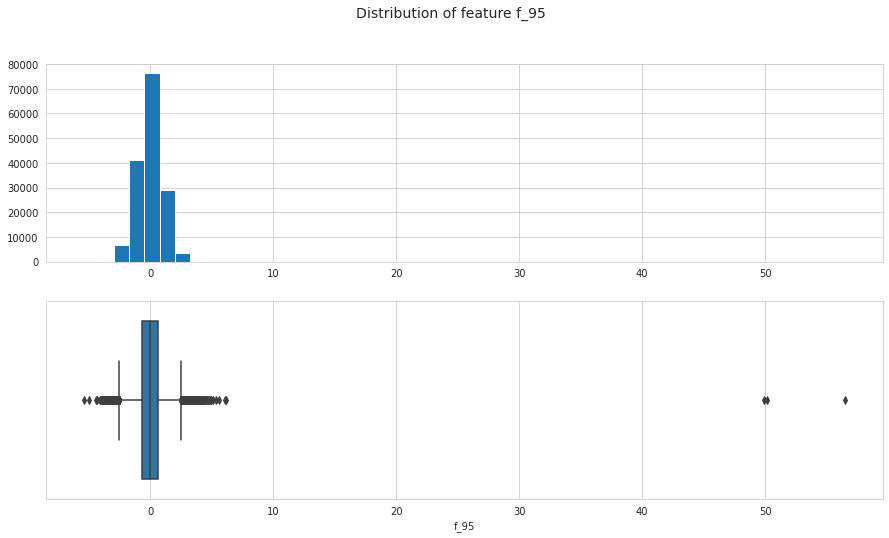

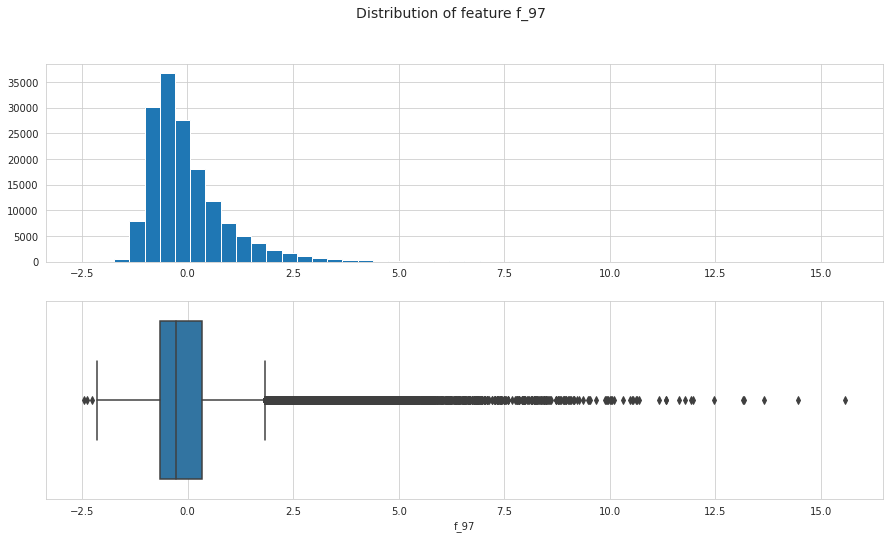

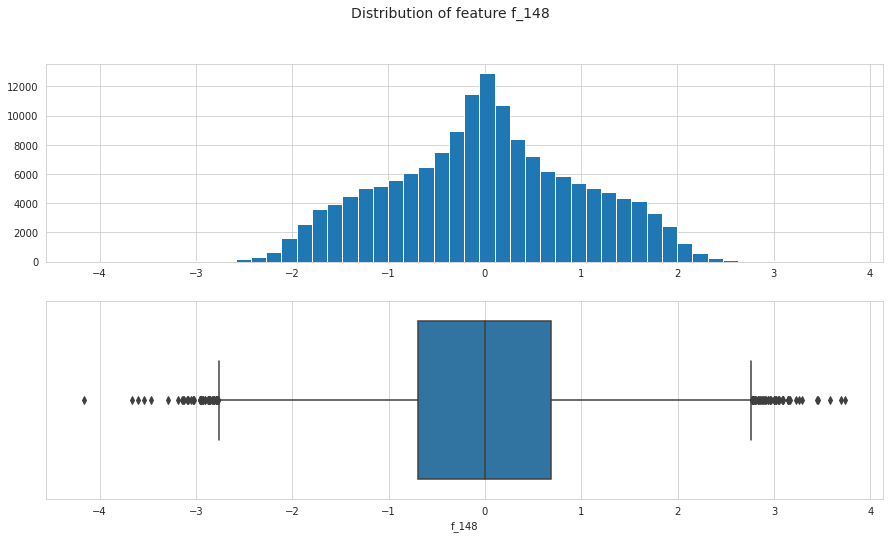

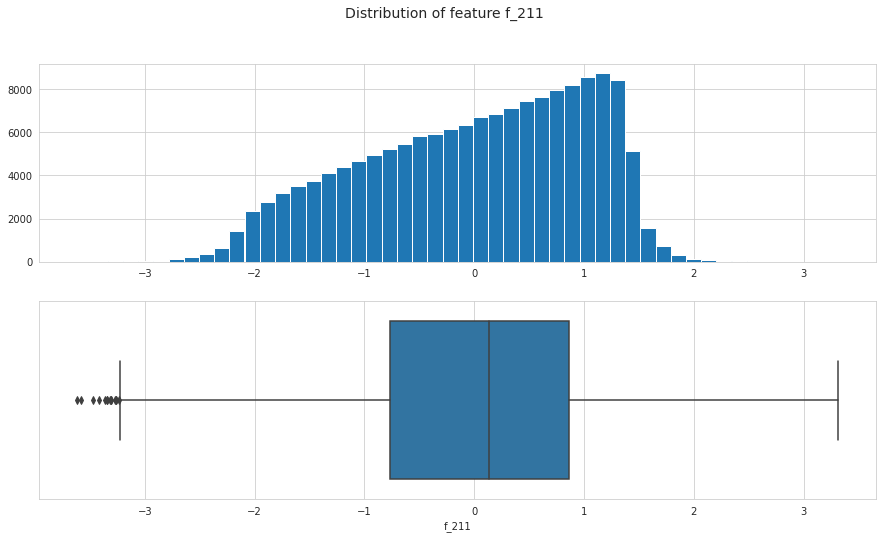

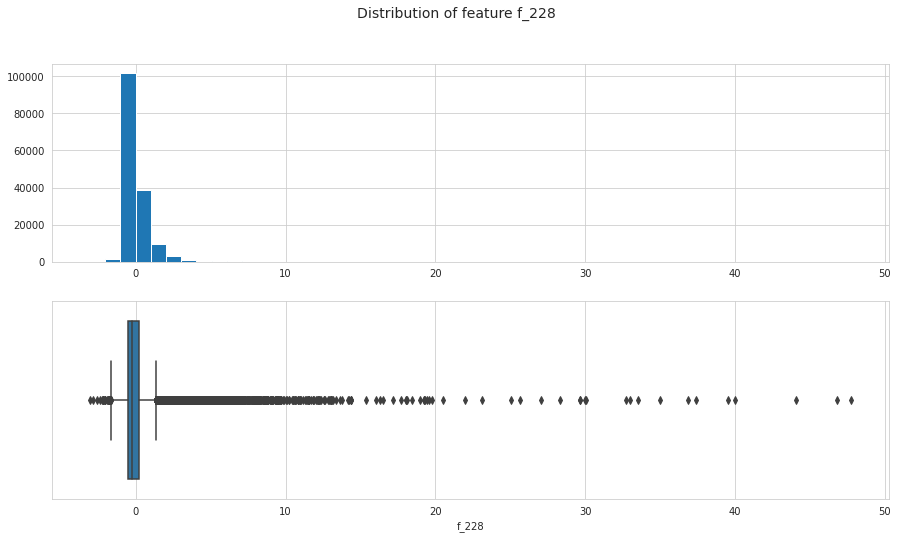

In [43]:
# Plot histograms and boxplot of these features f_
for f in feat_common:
    
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature {}".format(f), size=14)
    
    # Target histogram
    sample_df["{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="{}".format(f), data=sample_df, ax=axes[1])
    plt.show()

Distribution are not all centered in zero. Many outliers.

So we are going to compare 2 possibilities : upper matrix and lower matrix.

In [44]:
# Drop these features
sample_df_up = sample_df.drop(to_drop_up, axis=1)
sample_df_low = sample_df.drop(to_drop_low, axis=1)

In [45]:
print("sample_df_up shape : ", sample_df_up.shape)
print("sample_df_low shape : ", sample_df_low.shape)

sample_df_up shape :  (157070, 284)
sample_df_low shape :  (157070, 284)


In [46]:
# Remove others columns that are not "features"
others = ["row_id", "time_id", "investment_id", "target"]

features_up = list(sample_df_up.columns)
features_low = list(sample_df_low.columns)

for x in others:
    features_up.remove(x)
    features_low.remove(x)

In [47]:
len(features_up)

280

In [48]:
len(features_low)

280

Correlated features have been removed.

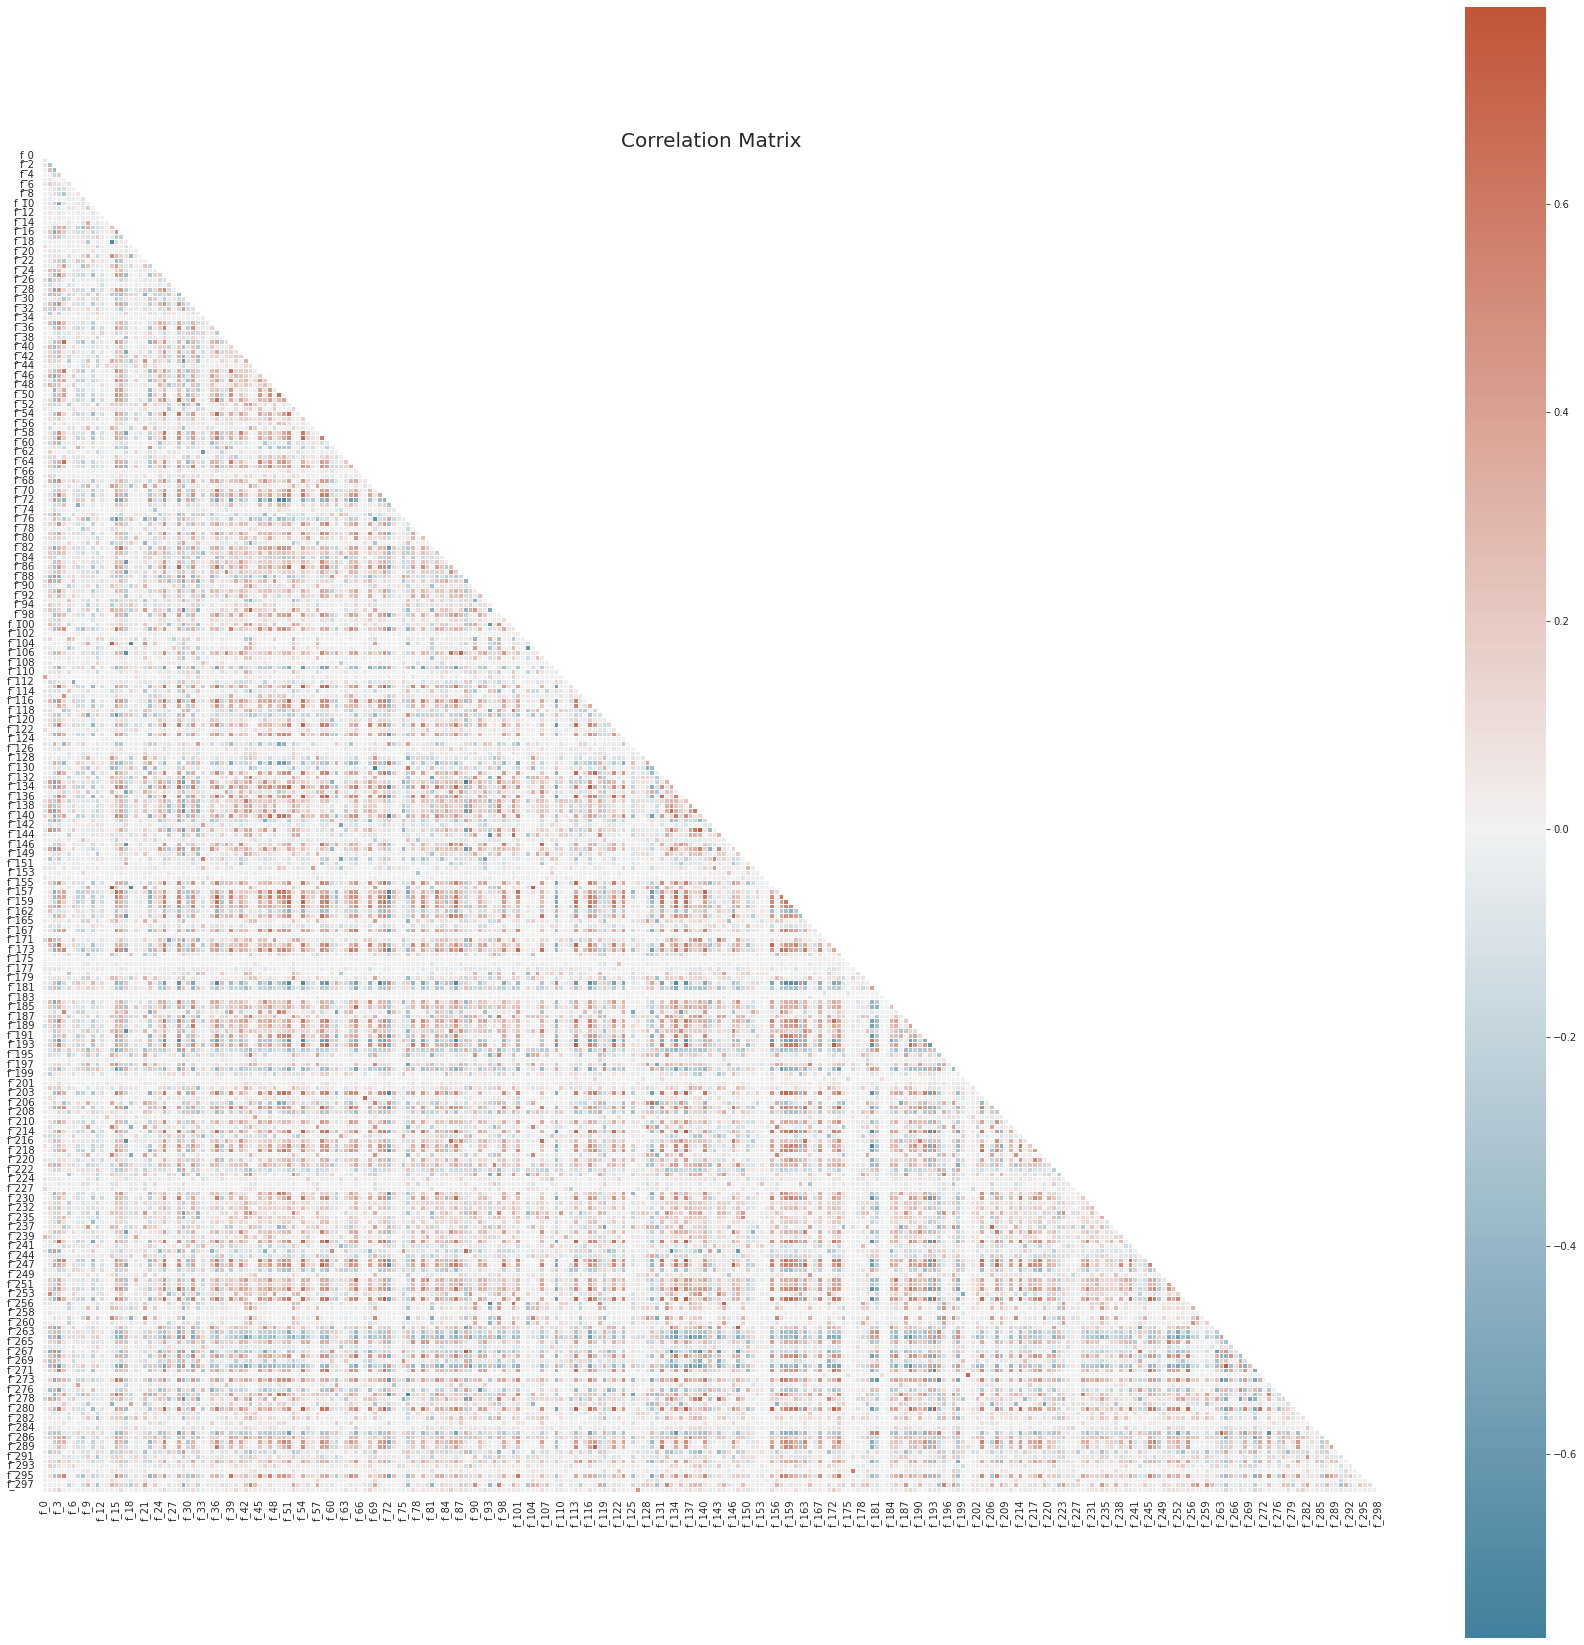

In [49]:
# Let's have a look at correlation matrix
mat_corr(sample_df[features_up])

It remains some correlation above 0.6 in absolute value.

## Split data
We are going to split data now in order that the test part is not influenced by operations done on the train part.

In [50]:
# Define X and y
X = sample_df[features].values
X_up = sample_df_up.drop(others, axis=1).values
X_low = sample_df_low.drop(others, axis=1).values
y = sample_df_up["target"].values

In [51]:
print("X shape : ", X.shape)
print("X_up shape : ", X_up.shape)
print("X_low shape : ", X_low.shape)
print("y shape : ", y.shape)

X shape :  (157070, 300)
X_up shape :  (157070, 280)
X_low shape :  (157070, 280)
y shape :  (157070,)


The test part has to be the end of the dataset as it is "the future" observations (remember that our data are ordered by time_id).

In [52]:
# Split data
X_train = X[:140000]
X_test = X[140000:]

X_up_train = X_up[:140000]
X_up_test = X_up[140000:]

X_low_train = X_low[:140000]
X_low_test = X_low[140000:]

y_train = y[:140000]
y_test = y[140000:]

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("X_up_train shape : ", X_up_train.shape)
print("X_up_test shape : ", X_up_test.shape)
print("X_low_train shape : ", X_low_train.shape)
print("X_low_test shape : ", X_low_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (140000, 300)
X_test shape :  (17070, 300)
X_up_train shape :  (140000, 280)
X_up_test shape :  (17070, 280)
X_low_train shape :  (140000, 280)
X_low_test shape :  (17070, 280)
y_train shape :  (140000,)
y_test shape :  (17070,)


In [53]:
perc_test = round(len(X_up_test) / len(X_up) * 100, 1)
print("Percent of data in test set : {}%".format(perc_test))

Percent of data in test set : 10.9%


In [54]:
# Let's see information about the first line of testset
sample_df.loc[140000]

row_id           1116_3430
time_id             1116.0
investment_id       3430.0
target            0.038818
f_0               0.500488
                   ...    
f_295            -0.315186
f_296             1.768555
f_297            -0.768066
f_298             -1.68457
f_299            -0.147949
Name: 140000, Length: 304, dtype: object

Test set contains data with time_id above 1116.

In [55]:
sample_df.loc[139999]

row_id           1116_3411
time_id             1116.0
investment_id       3412.0
target           -0.509277
f_0               0.243164
                   ...    
f_295             0.433838
f_296              0.69873
f_297            -0.566895
f_298             1.151367
f_299             0.062927
Name: 139999, Length: 304, dtype: object

In [56]:
sample_df.loc[140001]

row_id           1116_3482
time_id             1116.0
investment_id       3482.0
target           -1.803711
f_0               0.908203
                   ...    
f_295            -0.540527
f_296              0.38916
f_297             1.701172
f_298             1.555664
f_299            -0.269287
Name: 140001, Length: 304, dtype: object

## Preprocessing
We are going to consider PCA in order to decrease the number of features.

We are going to compare normalized data and unnormalized data. As mentioned above, we are going to use Robust Scaler for normalization.

### Scale

In [57]:
# X
robust_scal = RobustScaler().fit(X_train)
X_scaled = robust_scal.transform(X_train)
X_scaled.shape

(140000, 300)

In [58]:
# Up
robust_scal_up = RobustScaler().fit(X_up_train)
X_up_scaled = robust_scal_up.transform(X_up_train)
X_up_scaled.shape

(140000, 280)

In [59]:
# Low
robust_scal_low = RobustScaler().fit(X_low_train)
X_low_scaled = robust_scal_low.transform(X_low_train)
X_low_scaled.shape

(140000, 280)

### PCA

In [60]:
# PCA X
pca = PCA(random_state=0)
pca.fit(X_train)

PCA(random_state=0)

In [61]:
def display_scree_plot(pca, data):

    """ Function to display eigenvalues scree of pca
        
    - Arguments :
        - pca : pca model fitted
        - data : data on which PCA has been fitted (string)
    
    - Display :
        - barplot for each pca component
        - cumulated inertie percent (variance explained by pca) 
    """
    
    # Initiate plot
    plt.figure(figsize=(12, 8))
    
    # Get explained_variance_ratio_
    scree = pca.explained_variance_ratio_ * 100

    # Barplot for each component
    plt.bar(np.arange(len(scree)) + 1, scree)

    # Cumulative sum
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")

    plt.xlabel("rank of the axis of inertia", size=13)
    plt.ylabel("Inertie percent", size=13)
    plt.title("Eigenvalues scree of pca for {}".format(data), size=14)
    plt.show(block=False)

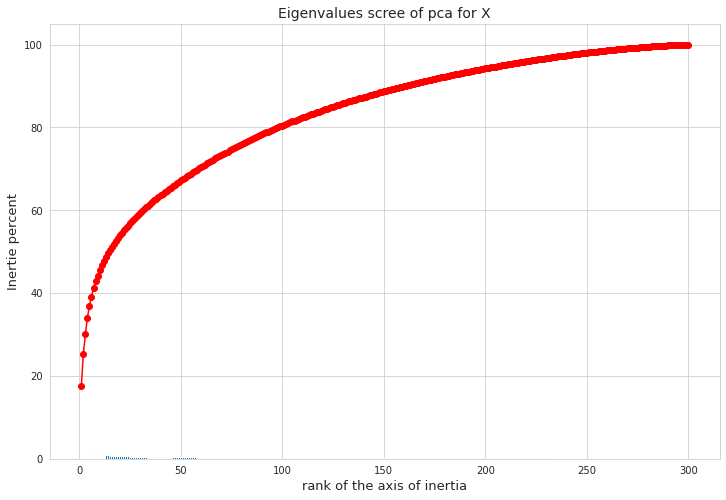

In [62]:
data = "X"
display_scree_plot(pca, data)

In [63]:
# PCA 0.85 X
pca_85 = PCA(n_components=0.85, random_state=0)
pca_85.fit(X_train)
X_pca85 = pca_85.transform(X_train)
X_pca85.shape

(140000, 125)

The features number decreases of 58%.

In [64]:
# PCA X_up
pca_up = PCA(random_state=0)
pca_up.fit(X_up_train)

PCA(random_state=0)

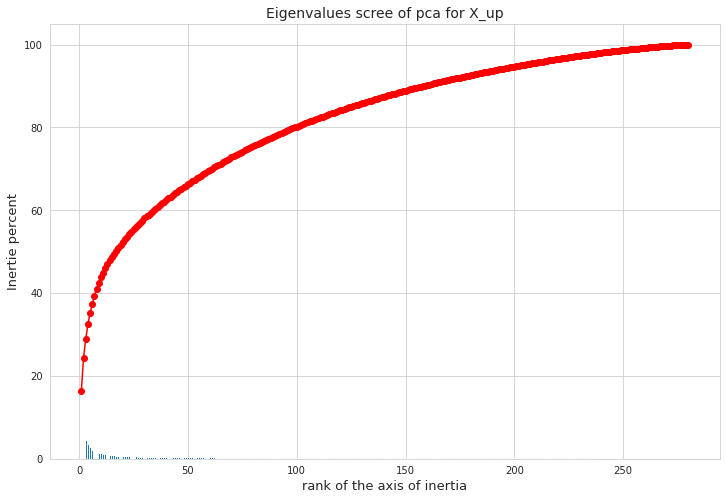

In [65]:
data = "X_up"
display_scree_plot(pca_up, data)

Let's keep 85% of explained variance.

In [66]:
# PCA 0.85 X_up
pca_up_85 = PCA(n_components=0.85, random_state=0)
pca_up_85.fit(X_up_train)
X_up_pca85 = pca_up_85.transform(X_up_train)
X_up_pca85.shape

(140000, 126)

The features number decreases of 55%.

In [67]:
# PCA X_low
pca_low = PCA(random_state=0)
pca_low.fit(X_low_train)

PCA(random_state=0)

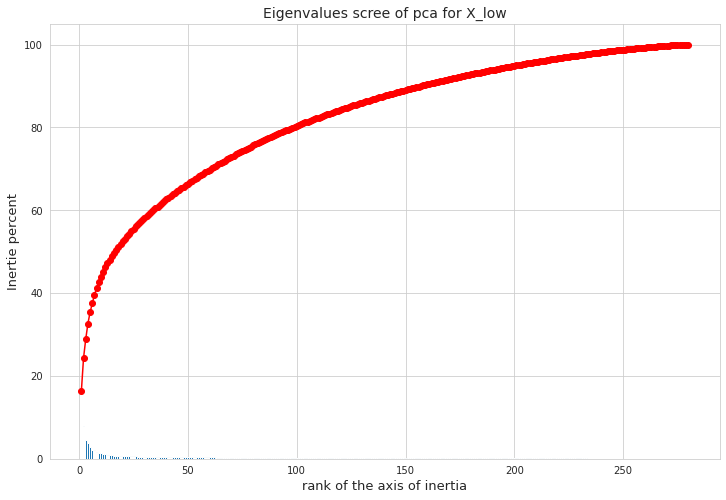

In [68]:
data = "X_low"
display_scree_plot(pca_low, data)

In [69]:
# PCA 0.85 X_low
pca_low_85 = PCA(n_components=0.85, random_state=0)
pca_low_85.fit(X_low_train)
X_low_pca85 = pca_low_85.transform(X_low_train)
X_low_pca85.shape

(140000, 125)

The features number decreases of 55.4%.

In [70]:
# PCA X_scaled
pca_scal = PCA(random_state=0)
pca_scal.fit(X_scaled)

PCA(random_state=0)

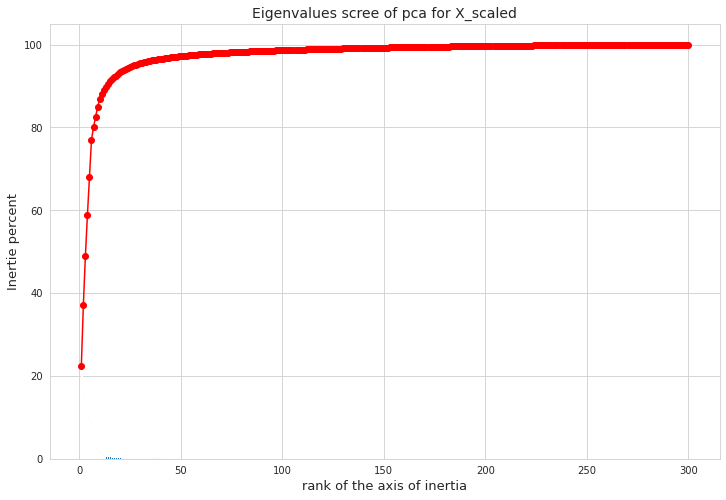

In [71]:
data = "X_scaled"
display_scree_plot(pca_scal, data)

In [72]:
# PCA 0.85 X_scaled
pca_scal_85 = PCA(n_components=0.85, random_state=0)
pca_scal_85.fit(X_scaled)
X_scal_pca85 = pca_scal_85.transform(X_scaled)
X_scal_pca85.shape

(140000, 10)

The features number decreases of 96.7% !

In [73]:
# PCA X_up_scaled
pca_up_scal = PCA(random_state=0)
pca_up_scal.fit(X_up_scaled)

PCA(random_state=0)

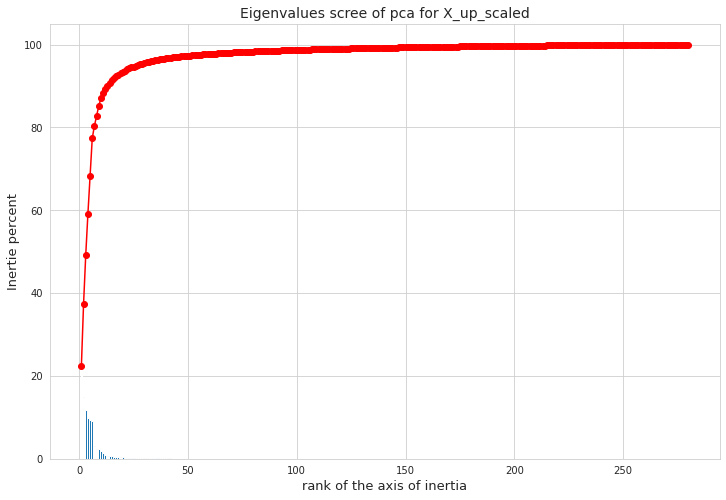

In [74]:
data = "X_up_scaled"
display_scree_plot(pca_up_scal, data)

In [75]:
# PCA 0.85 X_up_scaled
pca_up_scal_85 = PCA(n_components=0.85, random_state=0)
pca_up_scal_85.fit(X_up_scaled)
X_up_scal_pca85 = pca_up_scal_85.transform(X_up_scaled)
X_up_scal_pca85.shape

(140000, 9)

The features number decreases of 96.8% !

In [76]:
# PCA X_low_scaled
pca_low_scal = PCA(random_state=0)
pca_low_scal.fit(X_low_scaled)

PCA(random_state=0)

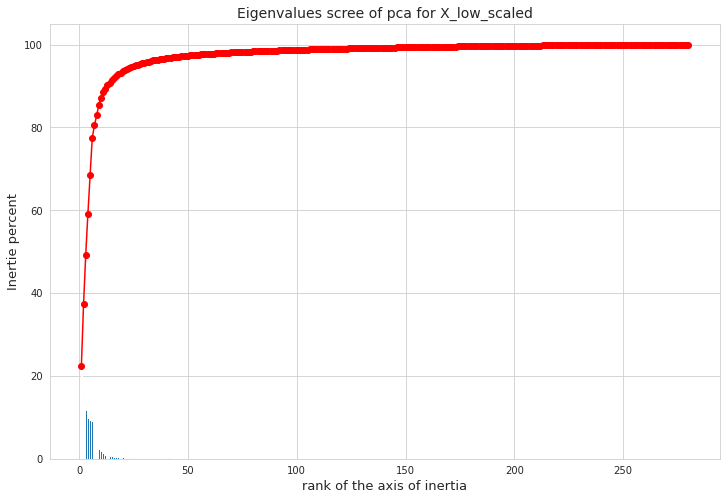

In [77]:
data = "X_low_scaled"
display_scree_plot(pca_low_scal, data)

In [78]:
# PCA 0.85 X_low_scaled
pca_low_scal_85 = PCA(n_components=0.85, random_state=0)
pca_low_scal_85.fit(X_low_scaled)
X_low_scal_pca85 = pca_low_scal_85.transform(X_low_scaled)
X_low_scal_pca85.shape

(140000, 9)

The features number decreases of 96.8% !

## Linear Regression
### 1st Try 
We are going to see on a simple linear regression how models perform with our different data (PCA, up, down, scaled..).

In [79]:
def display_learning_curve(model, X_train, y_train, name_model, name_X):

    """ Function to display learning curve for a model
    
    - Arguments : 
        - model : model to train
        - X_train : data to fit
        - y_train : data to compare
        - name_model : name of the model (string)
        - name_X : name of X_data (string)
    
    - Display :
        - Learning curve with training score and validation score
    
    """
    N, train_score, val_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=n_folds,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1, 10),
    )

    # Plot learning-curve
    plt.figure(figsize=(6, 6))
    plt.plot(N, -train_score.mean(axis=1), label="train_score")
    plt.plot(N, -val_score.mean(axis=1), label="validation_score")
    plt.xlabel("Dataset size", size=14)
    plt.ylabel("Mean RMSE", size=14)
    # plt.xlim([50,680])
    # plt.ylim([y_min, y_max])

    plt.title("Learning curve for {} with {}".format(name_model, name_X), size=14)
    plt.legend()
    plt.show()

In [80]:
def my_scorer(X, y):
    """
    Function to get Pearson correlation coefficient between X and y
    
    Arguments :
        - X
        _ y
    
    Returns :
        - Pearson correlation coefficient computed with 
        scipy.stats module
    """
    pearson = pearsonr(X, y)[0]
    return pearson

# Let's transform my_scorer has a scorer
my_pearson = make_scorer(my_scorer, greater_is_better=True)

# Dictionnay of scores
scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "my_pearson": my_pearson,
}

In [81]:
def cross_val(model, X_train, y_train, name_model, name_X):

    """ Function to do cross-validation on a model and get scores in
    a dataframe 
        
    - Arguments :
        - model : model to test
        - X_train : X data 
        - y_train : X data
        - name_model : name of the model (string)
        - name_X : name given to the X data (string)
    
    - Return :
        - dataframe with name_model, name_X and scoring : RMSE, MAE, R2
    """

    # Cross validation
    scores = cross_validate(model, X_train, y_train, cv=n_folds, scoring=scoring,)

    # Get mean scores
    RMSE = -scores["test_neg_root_mean_squared_error"].mean()
    MAE = -scores["test_neg_mean_absolute_error"].mean()
    pearson = scores["test_my_pearson"].mean()

    # Dataframe creation for results
    df_model = pd.DataFrame(
        [[name_model, name_X, RMSE, MAE, pearson]],
        columns=["model", "X_data", "RMSE", "MAE", "Pearson_coef"],
    )

    return df_model

In [82]:
# Dico of X_data
dico_X = {
    "X_train": X_train,
    "X_scaled": X_scaled,
    "X_pca85": X_pca85,
    "X_scal_pca85": X_scal_pca85,
    "X_up_pca85": X_up_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_pca85": X_low_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

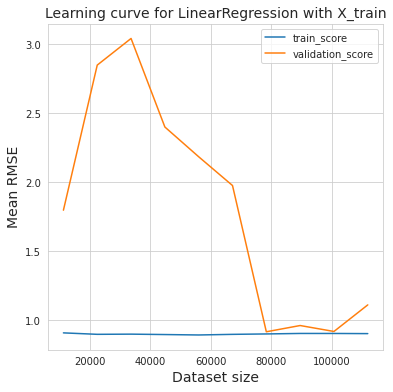

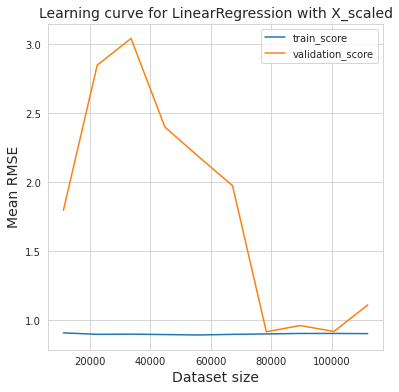

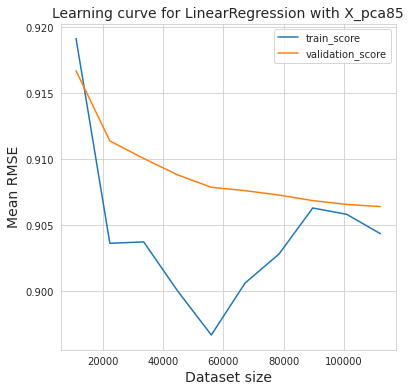

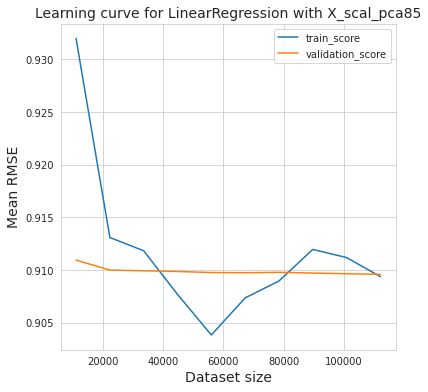

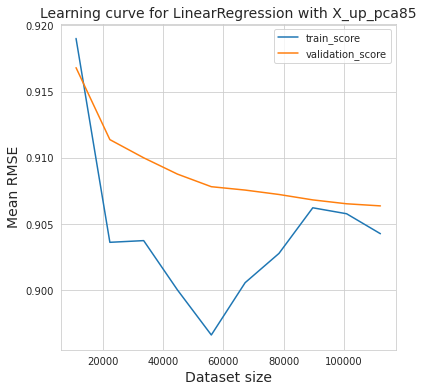

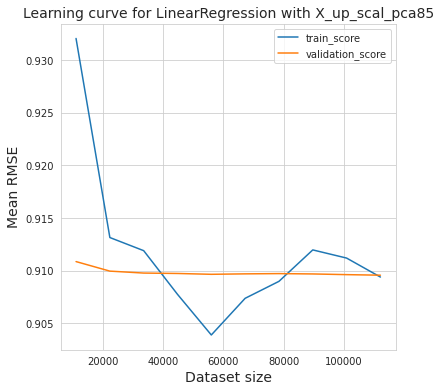

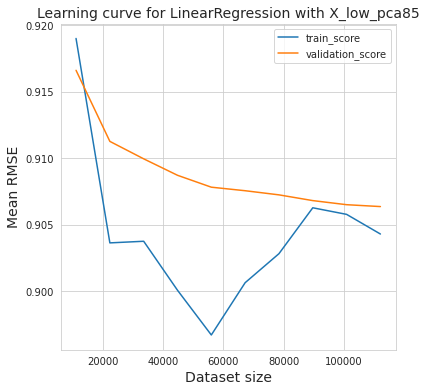

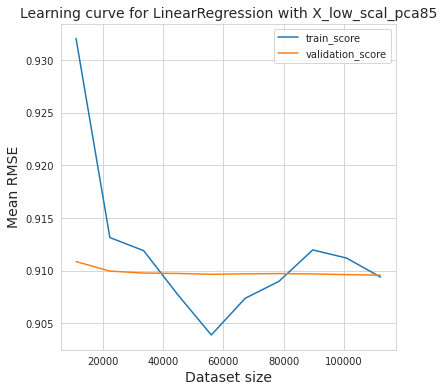

CPU times: user 13min 33s, sys: 3min 36s, total: 17min 9s
Wall time: 6min 36s


,model,X_data,RMSE,MAE,Pearson_coef
0,LinearRegression,X_train,1.110800,0.629590,0.088364
0,LinearRegression,X_scaled,1.110791,0.629590,0.088364
0,LinearRegression,X_pca85,0.906405,0.626232,0.113346
0,LinearRegression,X_scal_pca85,0.909607,0.628624,0.074268
0,LinearRegression,X_up_pca85,0.906377,0.626210,0.113571
0,LinearRegression,X_up_scal_pca85,0.909573,0.628585,0.074763
0,LinearRegression,X_low_pca85,0.906365,0.626174,0.113570
0,LinearRegression,X_low_scal_pca85,0.909570,0.628582,0.074811


In [83]:
%%time

model = LinearRegression()
n_folds = 5

# Dataframe for results
lr_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "LinearRegression", name_X)
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results = pd.concat([lr_results, df_lr], axis = 0)

lr_results

In [84]:
lr_results = lr_results.reset_index(drop=True)
lr_results.sort_values(by = "RMSE")

,model,X_data,RMSE,MAE,Pearson_coef
6,LinearRegression,X_low_pca85,0.906365,0.626174,0.113570
4,LinearRegression,X_up_pca85,0.906377,0.626210,0.113571
2,LinearRegression,X_pca85,0.906405,0.626232,0.113346
7,LinearRegression,X_low_scal_pca85,0.909570,0.628582,0.074811
5,LinearRegression,X_up_scal_pca85,0.909573,0.628585,0.074763
3,LinearRegression,X_scal_pca85,0.909607,0.628624,0.074268
1,LinearRegression,X_scaled,1.110791,0.629590,0.088364
0,LinearRegression,X_train,1.110800,0.629590,0.088364


In [85]:
lr_results.sort_values(by = "MAE")

,model,X_data,RMSE,MAE,Pearson_coef
6,LinearRegression,X_low_pca85,0.906365,0.626174,0.113570
4,LinearRegression,X_up_pca85,0.906377,0.626210,0.113571
2,LinearRegression,X_pca85,0.906405,0.626232,0.113346
7,LinearRegression,X_low_scal_pca85,0.909570,0.628582,0.074811
5,LinearRegression,X_up_scal_pca85,0.909573,0.628585,0.074763
3,LinearRegression,X_scal_pca85,0.909607,0.628624,0.074268
1,LinearRegression,X_scaled,1.110791,0.629590,0.088364
0,LinearRegression,X_train,1.110800,0.629590,0.088364


In [86]:
lr_results.sort_values(by = "Pearson_coef", ascending=False)

,model,X_data,RMSE,MAE,Pearson_coef
4,LinearRegression,X_up_pca85,0.906377,0.626210,0.113571
6,LinearRegression,X_low_pca85,0.906365,0.626174,0.113570
2,LinearRegression,X_pca85,0.906405,0.626232,0.113346
1,LinearRegression,X_scaled,1.110791,0.629590,0.088364
0,LinearRegression,X_train,1.110800,0.629590,0.088364
7,LinearRegression,X_low_scal_pca85,0.909570,0.628582,0.074811
5,LinearRegression,X_up_scal_pca85,0.909573,0.628585,0.074763
3,LinearRegression,X_scal_pca85,0.909607,0.628624,0.074268


Metrics are close to each other.
We can see that top3 is the same for each metric.

### Using TimeSeriesSplit
We are going to compare our different model of LinearRegression using TimeSeriesSplit : we are going to split data in cross validation with this.

In [87]:
# TimeSeriesSplit
ts_cv = TimeSeriesSplit(n_splits=5, test_size = 20000)

In [88]:
# Initiate counter
i = 1

# Get number of samples in each fold
for train_index, val_index in ts_cv.split(X_pca85):
    print(
        "Split ",
        i,
        "\nTrain nb of samples :",
        len(train_index),
        "Validation nb of samples :",
        len(val_index),
        "\n",
    )
    i += 1

Split  1 
Train nb of samples : 40000 Validation nb of samples : 20000 

Split  2 
Train nb of samples : 60000 Validation nb of samples : 20000 

Split  3 
Train nb of samples : 80000 Validation nb of samples : 20000 

Split  4 
Train nb of samples : 100000 Validation nb of samples : 20000 

Split  5 
Train nb of samples : 120000 Validation nb of samples : 20000 



#### Model training

In [89]:
%%time

model = LinearRegression()
n_folds = ts_cv

# Dataframe for results
lr_results_ts_cv = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results_ts_cv = pd.concat([lr_results_ts_cv, df_lr], axis = 0).reset_index(drop=True)

lr_results_ts_cv

CPU times: user 1min 19s, sys: 16.7 s, total: 1min 36s
Wall time: 37.7 s


,model,X_data,RMSE,MAE,Pearson_coef
0,LinearRegression,X_train,0.908742,0.621334,0.099488
1,LinearRegression,X_scaled,0.908742,0.621333,0.099486
2,LinearRegression,X_pca85,0.906315,0.618908,0.104366
3,LinearRegression,X_scal_pca85,0.908199,0.620276,0.072285
4,LinearRegression,X_up_pca85,0.906208,0.618814,0.105115
5,LinearRegression,X_up_scal_pca85,0.908129,0.620209,0.073281
6,LinearRegression,X_low_pca85,0.906224,0.618842,0.104907
7,LinearRegression,X_low_scal_pca85,0.908126,0.620206,0.073340


In [90]:
lr_results_ts_cv.sort_values(by="RMSE")

,model,X_data,RMSE,MAE,Pearson_coef
4,LinearRegression,X_up_pca85,0.906208,0.618814,0.105115
6,LinearRegression,X_low_pca85,0.906224,0.618842,0.104907
2,LinearRegression,X_pca85,0.906315,0.618908,0.104366
7,LinearRegression,X_low_scal_pca85,0.908126,0.620206,0.073340
5,LinearRegression,X_up_scal_pca85,0.908129,0.620209,0.073281
3,LinearRegression,X_scal_pca85,0.908199,0.620276,0.072285
0,LinearRegression,X_train,0.908742,0.621334,0.099488
1,LinearRegression,X_scaled,0.908742,0.621333,0.099486


Top 3 is the same, RMSE ans MAE are better, but Pearson_coef is worse (except when trained on all data).

We choose X_up_pca85 as best pre processed data and we are going to evaluate this model. 

#### Model evaluation

In [91]:
# Create Pipeline
pipeline_lr = Pipeline(
    [("pca", PCA(n_components=0.85, random_state=0)), ("lr", LinearRegression()),]
)

# Model training
pipeline_lr.fit(X_up_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('lr', LinearRegression())])

In [92]:
# Create Pipeline
pipeline_lr = Pipeline(
    [("pca", PCA(n_components=0.85, random_state=0)), ("lr", LinearRegression()),]
)

# Model training
pipeline_lr.fit(X_up_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('lr', LinearRegression())])

In [93]:
def get_scores(model, name_model, name_X, X_test, y_test):

    """
    Function to get target predictions and dataframe with
    metrics
    
    Arguments : 
    - model : model to evaluate
    - name_model : name of the model (string)
    - name_X : name of the data (string)
    - X_test : data to get predictions
    - y_test : actual target values
    
    Return :
    - y_pred : array of predictions values
    - results : dataframe with name_model, name_X, RMSE and
    Pearson_coef
    
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Get scores
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    pearson = pearsonr(y_pred, y_test)[0]

    # Data frame for results
    results = pd.DataFrame(
        [[name_model, name_X, RMSE, pearson]],
        columns=["model", "X_data", "RMSE", "Pearson_coef"],
    )

    return y_pred, results

In [94]:
# Model evaluation
y_pred, lr_final = get_scores(
    pipeline_lr, "LinearRegression", "X_up_pca85", X_up_test, y_test
)
lr_final

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.89762,0.094725
